In [1]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import h5py
import numpy as np

# Data

In [2]:
ras = []
decs = []
haloID = []
GalaxyID = []
mass = []
hmass = []
redshift = []

for i in range(512):
    fname = f'./mmodel/BzKdeep/Bower06.BzK.KenIMF.{i}.hdf5'
    
    with h5py.File(fname, 'r') as f:

        ras.extend(list(f['Data']['ra'][:]))
        decs.extend(list(f['Data']['dec'][:]))
        haloID.extend(list(f['Data']['DHaloID'][:]))
        GalaxyID.extend(list(f['Data']['GalaxyID'][:]))
        mass.extend(list(f['Data']['mstars_tot'][:]))
        hmass.extend(list(f['Data']['mhhalo'][:]))
        redshift.extend(list(f['Data']['z_obs'][:]))


In [3]:
len(ras)

41690599

In [4]:
len(set(haloID))

32110464

In [5]:
import pickle

In [7]:
with open('./mmodel/BzKdeep/ra', 'wb') as f:
    pickle.dump(ras, f)

with open('./mmodel/BzKdeep/dec', 'wb') as f:
    pickle.dump(decs, f)

with open('./mmodel/BzKdeep/haloID', 'wb') as f:
    pickle.dump(haloID, f)
    
with open('./mmodel/BzKdeep/galID', 'wb') as f:
    pickle.dump(GalaxyID, f)
    
with open('./mmodel/BzKdeep/mass', 'wb') as f:
    pickle.dump(mass, f)
    
with open('./mmodel/BzKdeep/hmass', 'wb') as f:
    pickle.dump(hmass, f)

with open('./mmodel/BzKdeep/redshift', 'wb') as f:
    pickle.dump(redshift, f)

# Density field

In [2]:
import pickle

In [3]:
with open('./mmodel/BzKdeep/ra', 'rb') as f:
    ras = pickle.load(f)

with open('./mmodel/BzKdeep/dec', 'rb') as f:
    decs = pickle.load(f)

with open('./mmodel/BzKdeep/haloID', 'rb') as f:
    haloID = pickle.load(f)
    
with open('./mmodel/BzKdeep/galID', 'rb') as f:
    galID = pickle.load(f)
    
with open('./mmodel/BzKdeep/mass', 'rb') as f:
    mass = pickle.load(f)
    
with open('./mmodel/BzKdeep/hmass', 'rb') as f:
    hmass = pickle.load(f)

with open('./mmodel/BzKdeep/redshift', 'rb') as f:
    redshift = pickle.load(f)

In [4]:
ras = np.array(ras)
decs = np.array(decs)
zs = np.array(redshift)

In [69]:
galID_arr = np.array(galID)
haloID_arr = np.array(haloID)

hmass = np.array(hmass)

In [5]:
ras = ras * 180 / np.pi
decs = decs * 180 / np.pi

In [6]:
#find grid step: 100kpc
def find_grid_step(z):
    sep = cosmo.arcsec_per_kpc_proper(z) * 100 * u.kpc
    return sep.to(u.deg).value

#find bin size
def find_bin_size(z):
    del_z = 0.015 * (1+z)
    return del_z

#find search radius: 700kpc
def find_search_radius(z):
    r = cosmo.arcsec_per_kpc_proper(z) * 700 * u.kpc # arcsec
    
    return r.to(u.deg).value

In [7]:
redshifts = np.arange(0.1, 1.22, 0.01)
len(redshifts)

112

In [8]:
binsize = find_bin_size(redshifts)

In [9]:
import multiprocessing as mp
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u

from astropy.modeling import models, fitting
import os
import pickle
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [10]:
import os

In [68]:
#make folders

for i in range(100):
    
    path = f'./mmodel/BzKdeep/seeds/seed{i:02d}'
    os.mkdir(path)
    
    os.mkdir(path + '/bins')
    os.mkdir(path + '/bins/grid_x')
    os.mkdir(path + '/bins/grid_y')
    
    os.mkdir(path + '/binsz')
    os.mkdir(path + '/binsz/grid_x')
    os.mkdir(path + '/binsz/grid_y')

In [22]:
# consctruct density field
def construction(seed, idx):
    
    # set seed
    np.random.seed(seed)
    
    # set field boundaries
    ra_c = np.random.uniform(351, 354, 1)[0]
    dec_c = np.random.uniform(-16.5, -13, 1)[0]
    
    ras_sample = ras[(ras >= ra_c) & (ras < ra_c + 1.4) & (decs >= dec_c) & (decs < dec_c + 1.4)]
    decs_sample = decs[(ras >= ra_c) & (ras < ra_c + 1.4) & (decs >= dec_c) & (decs < dec_c + 1.4)]
    specz_sample = zs[(ras >= ra_c) & (ras < ra_c + 1.4) & (decs >= dec_c) & (decs < dec_c + 1.4)]

    zerrs = np.random.normal(0, 0.01, len(specz_sample))
    
    photz_sample = specz_sample + zerrs
    
    ##########################################################################
    
    bs = binsize[idx] #binsize
    z = redshifts[idx]
    zmask = (specz_sample <=  z + bs) & (specz_sample >= z - bs)
    
    zmask2 = (photz_sample <= z + bs) & (photz_sample >= z - bs)
    
    print(f'{idx}', end = ' ')
    
    #grid separation = 0.1Mpc, with no z error
    gstep = find_grid_step(z)
    grid_ra = np.arange(min(ras_sample[zmask]), max(ras_sample[zmask]), gstep)
    grid_dec = np.arange(min(decs_sample[zmask]), max(decs_sample[zmask]), gstep)
    
    grid = np.zeros((len(grid_dec), len(grid_ra)))
    
    for j in range(len(grid_ra)):
        for i in range(len(grid_dec)):
            #within 1Mpc, z -> z_cl +- error
            sr = find_search_radius(z)
            
            smask = ((ras_sample[zmask] -  grid_ra[j])**2 + (decs_sample[zmask] - grid_dec[i])**2 < sr**2)
            grid[i, j] = len(ras_sample[zmask][smask])
    
    np.save(f'./mmodel/BzKdeep/seeds/seed{seed:02d}/bins/bins_{idx:03d}', grid)        
    
    
    #################################################################################
    #with z error
    gstep2 = find_grid_step(z)
    grid_ra2 = np.arange(min(ras_sample[zmask2]), max(ras_sample[zmask2]), gstep2)
    grid_dec2 = np.arange(min(decs_sample[zmask2]), max(decs_sample[zmask2]), gstep2)
    
    grid2 = np.zeros((len(grid_dec2), len(grid_ra2)))
    
    for j in range(len(grid_ra2)):
        for i in range(len(grid_dec2)):
            #within 1Mpc, z -> z_cl +- error
            sr = find_search_radius(z)
            
            smask = ((ras_sample[zmask2] -  grid_ra2[j])**2 + (decs_sample[zmask2] - grid_dec2[i])**2 < sr**2)
            grid2[i, j] = len(ras_sample[zmask2][smask])
    
    np.save(f'./mmodel/BzKdeep/seeds/seed{seed:02d}/binsz/bins_{idx:03d}', grid2)      
    
    
    ### grid_x, grid_y ###
    grid_x, grid_y = np.meshgrid(grid_ra, grid_dec)
    grid_x2, grid_y2 = np.meshgrid(grid_ra2, grid_dec2)

    np.save(f'./mmodel/BzKdeep/seeds/seed{seed:02d}/bins/grid_x/gird_x_{idx:03d}', grid_x)
    np.save(f'./mmodel/BzKdeep/seeds/seed{seed:02d}/bins/grid_y/gird_y_{idx:03d}', grid_y)
    
    np.save(f'./mmodel/BzKdeep/seeds/seed{seed:02d}/binsz/grid_x/gird_x_{idx:03d}', grid_x2)
    np.save(f'./mmodel/BzKdeep/seeds/seed{seed:02d}/binsz/grid_y/gird_y_{idx:03d}', grid_y2)
    
    print(f'{idx} completed')

In [23]:
from functools import partial

In [24]:
# for i in range(1, 100):
        
#     func = partial(construction, i)
    
#     print(f'seed = {i}')
    
#     n = 6 #number of cores to use
#     with mp.Pool(n) as p:
#         p.map(func, range(len(redshifts)))
        
s = 0

func = partial(construction, s)

print(f'seed = {s}')

n = 8 #number of cores to use

with mp.Pool(n) as p:
    p.map(func, range(len(redshifts)))
        

seed = 0
2028  12 0 24 4 16 8 0 completed
1 4 completed
5 1 completed
2 8 completed
9 2 completed
3 5 completed
6 12 completed
13 16 completed
17 3 completed
32 9 completed
10 6 completed
7 20 completed
21 24 completed
25 13 completed
14 7 completed
36 28 completed
29 10 completed
11 17 completed
18 14 completed
15 11 completed
40 21 completed
22 32 completed
33 25 completed
26 18 completed
19 15 completed
44 29 completed
30 36 completed
37 22 completed
23 19 completed
48 26 completed
27 40 completed
41 33 completed
34 30 completed
31 23 completed
52 37 completed
38 44 completed
45 27 completed
56 31 completed
60 34 completed
35 48 completed
49 41 completed
42 38 completed
39 52 completed
53 45 completed
46 35 completed
64 42 completed
43 56 completed
57 49 completed
50 39 completed
68 60 completed
61 46 completed
47 53 completed
54 43 completed
72 50 completed
51 64 completed
65 57 completed
58 47 completed
76 61 completed
62 68 completed
69 54 completed
55 51 completed
80 72 complete

# check overdensity

In [26]:
def overdense(od):
    od_ra = []
    od_dec = []
    od_z = []

    for i in range(len(redshifts)):
    # for i in range(1):
        od_z_ra = []
        od_z_dec = []
        od_z_z = []
        print(i, end = ' ')
        
        grid = np.load(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/' + file_listz[i])

        #grid separation = 0.1Mpc
        bs = binsize[i] #binsize
        z = redshifts[i]

        gstep = find_grid_step(redshifts[i])

        grid_x = np.load(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/grid_x/' + xlistz[i])
        grid_y = np.load(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/grid_y/' + ylistz[i])


        grid_1d = np.concatenate(grid)
        
        mean = grid_1d.mean()
        std = grid_1d.std()
        
        overdense_mask = grid >= mean + od * std
        sparse_mask = grid < mean + od * std

        ras = grid_x[overdense_mask]
        decs = grid_y[overdense_mask]

        plt.figure()

        plt.scatter(np.concatenate(grid_x), np.concatenate(grid_y), color = 'grey', alpha =  .005)
        plt.scatter(ras, decs, color = 'royalblue', alpha =  .3)

        #save checked
        checked = np.full(ras.shape, True, dtype = bool)

        for k in range(len(ras)):
            #itself
            if not checked[k]:
                print('already checekd')
                continue
            else:
                print('find its first friends')

            ra = ras[k]
            dec = decs[k]
            checked[k] = False

    #         temp_checked = []

            coord_mask = ((ras - ra)**2 + (decs - dec)**2 <=  2 *gstep**2)  
            check_index = np.where(ras[coord_mask & checked])[0]

            #if it has no member
            if len(ras[coord_mask & checked]) == 0:
                print('no friends found')
                continue

            #friends
            friends_ra = ras[coord_mask & checked]
            friends_dec = decs[coord_mask & checked]
            checked[check_index] = False

            #update
            final_ra = np.concatenate([np.array([ra]), friends_ra])
            final_dec = np.concatenate([np.array([dec]), friends_dec])

            #find its friends of friends
            flag = True
            first = True

            new_ra = np.array([])
            new_dec = np.array([])
            while flag:

                if first:
                    first = False
                    cand_ra = friends_ra.copy()
                    cand_dec = friends_dec.copy()
                else:
                    cand_ra = temp_ra.copy()
                    cand_dec = temp_dec.copy()


                temp_ra = np.array([])
                temp_dec = np.array([])

                for l in range(len(cand_ra)):
                    ra2 = cand_ra[l]
                    dec2 = cand_dec[l]
                    sec_index = np.where((ras == ra2) & (decs == dec2))[0]

                    if not checked[sec_index]:
                        continue
                    else:
                        checked[sec_index] = False

                    coord_mask2 = ((ras - ra2)**2 + (decs - dec2)**2 <= 2 * gstep**2)
                    check_index2 = np.where(ras[coord_mask2 & checked])[0] 

                    if len(ras[coord_mask2 & checked])  == 0:
                        continue


                    #friends
                    temp_ra = np.concatenate([temp_ra, ras[coord_mask2 & checked]])
                    temp_dec = np.concatenate([temp_dec, decs[coord_mask2 & checked]])

                    checked[check_index2] = False

                if len(temp_ra) > 0:
                    print(f'+{len(temp_ra)}')
                    new_ra = np.concatenate([new_ra, temp_ra])
                    new_dec= np.concatenate([new_dec, temp_dec])
                else:
                    flag = False


            final_ra = np.concatenate([final_ra, new_ra])
            final_dec = np.concatenate([final_dec, new_dec])

            if len(final_ra) >= 10:        
                od_z_ra.append(final_ra)
                od_z_dec.append(final_dec)
                od_z_z.append(i)

                plt.scatter(final_ra, final_dec, color = 'firebrick', alpha = .2, s = 10)

            else:
                plt.scatter(final_ra, final_dec, color = 'yellow', alpha = .2, s = 10)
                print('less than 10 members')
#         plt.savefig(f'check/check{i}.png')
        od_ra.append(od_z_ra)
        od_dec.append(od_z_dec)
        od_z.append(od_z_z)


    return od_ra, od_dec, od_z

In [27]:
def find_radius(z, r):
    r = cosmo.arcsec_per_kpc_proper(z) * r * u.Mpc # arcsec
    
    return r.to(u.deg).value

In [28]:
def find_connection(od_ra, od_dec, od_z):
    index1 = []
    index2 = []
    z_idx = []

    #just for check
    check_z = np.array([])  #check_1
    check_idx = np.array([]) # check_2

    for z in range(len(od_ra)-1):
        print(f'start {z}', end = ' ')
        for i in range(len(od_ra[z])):
            if len(od_ra[z][i]) > 9:
                print('enough connection')
            else:
                print('not enough!')
                continue

            ra_center = od_ra[z][i].mean()
            dec_center = od_dec[z][i].mean()

            zlist = []
            zlist.append(z)
            idxlist = [] #jlist
            idxlist.append(i) #jlist

            zid_list = []
            zid_list = [od_z[z][i]]

            zz = z  + 1
            print(' find its z friends')
            while True:
                if zz == len(od_ra) - 1:
                    print(' out of index')
                    break

                count = 0

                for j in range(len(od_ra[zz])):
                    ra_cand = od_ra[zz][j].mean()
                    dec_cand = od_dec[zz][j].mean()
                    
                    search = find_radius(redshifts[zz], 1)
                    
                    if (ra_center - ra_cand)**2 + (dec_center - dec_cand)**2 < search**2:
                        zlist.append(zz)
                        idxlist.append(j)
                        count += 1

                if count == 0:
                    print('no z friends')
                    break

                zz += 1

            if sum(np.isin(check_z, zlist) & np.isin(check_idx, idxlist)) > 0:
                print(' already counted')
            else:
                if len(zlist) > 2:
                    print(' found!')
                    index1.append(zlist)
                    index2.append(idxlist)
                    z_idx.append(zid_list)

                    check_z = np.concatenate([check_z, np.array(zlist)])
                    check_idx = np.concatenate([check_idx, np.array(idxlist)])


    return index1, index2, z_idx

0 find its first friends
+13
+26
+35
+32
+26
+25
+20
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd


6 find its first friends
+3
+6
+9
+13
+16
+18
+19
+19
+20
+20
+16
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

10 find its first friends
+3
+7
+11
+15
+19
+22
+24
+24
+25
+23
+21
+14
+14
+13
+13
+12
+10
+9
+9
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

12 find its first friends
+12
+25
+35
+44
+52
+60
+68
+74
+80
+86
+88
+90
+71
+59
+55
+46
+37
+26
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

14 find its first friends
+7
+16
+30
+43
+52
+58
+64
+70
+74
+80
+86
+90
+79
+71
+69
+67
+60
+53
+42
+30
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chec

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

17 find its first friends
+3
+7
+10
+13
+16
+18
+20
+22
+24
+25
+25
+26
+26
+20
+12
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+18
+33
+45
+55
+62
+67
+74
+71
+60
+58
+60
+60
+56
+45
+41
+41
+41
+40
+41
+41
+36
+31
+27
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


find its first friends
+3
+6
+9
+13
+16
+18
+16
+10
+8
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checek

21 find its first friends
+1
+2
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
no friends found
find its first friends
+3
+6
+8
+10
+13
+16
+18
+20
+21
+22
+22
+12
+11
+8
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

22 find its first friends
+8
+22
+37
+46
+53
+62
+64
+58
+38
+20
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

23 find its first friends
+12
+24
+32
+41
+52
+58
+64
+68
+70
+71
+71
+72
+69
+61
+59
+55
+49
+43
+34
+10
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checek

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

+61
+59
+57
+53
+49
+42
+30
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

29 find its first friends
+3
+5
+8
+11
+14
+16
+18
+20
+21
+22
+23
+22
+16
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already ch

30 find its first friends
+3
+7
+10
+13
+16
+18
+20
+21
+22
+23
+24
+24
+12
+10
+9
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

31 find its first friends
+3
+6
+8
+9
+11
+9
+6
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
no friends found
find its first friends
+1
+2
+3
+1
+1
+2
already checekd
find its first friends
no friends found
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+9
+12
+14
+15
+16
+18
+20
+21
+20
+14
+14
+13
+12
+10
+6
already 

32 find its first friends
+3
+5
+8
+10
+12
+13
+13
+13
+11
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+3
+3
+2
already checekd
already ch

33 find its first friends
+12
+25
+37
+49
+60
+67
+76
+82
+61
+47
+41
+33
+22
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already

34 find its first friends
+3
+7
+10
+13
+11
+10
+11
+10
+8
+7
+6
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
35 find its first friends
+3
+5
+8
+11
+13
+12
+11
+6
+4
+2
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

+98
+102
+97
+73
+68
+66
+47
+37
+26
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd


37 find its first friends
+3
+6
+9
+13
+16
+18
+19
+20
+21
+21
+21
+21
+19
+14
+6
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

38 find its first friends
+12
+24
+33
+44
+50
+54
+41
+33
+31
+27
+18
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

+39
+48
+54
+58
+50
+41
+37
+30
+9
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

40 find its first friends
+8
+20
+28
+37
+48
+54
+60
+66
+67
+57
+20
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd


+31
+40
+48
+56
+62
+66
+65
+38
+22
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+2
+2
+2
+3
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

+68
+74
+78
+82
+78
+72
+47
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

+18
+31
+41
+51
+58
+62
+57
+49
+47
+43
+39
+33
+13
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

44 find its first friends
+11
+20
+28
+37
+48
+56
+62
+68
+74
+78
+84
+88
+85
+77
+54
+10
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checek

45 find its first friends
+3
+6
+9
+13
+16
+18
+16
+12
+13
+13
+10
+8
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+10
+13
+15
+9
+9
+9
+9
+9
+9
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
46 find its first friends
+11
+20
+26
+32
+36
+38
+26
+17
+13
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already

47 find its first friends
+9
+16
+22
+28
+32
+29
+13
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+8
+18
+22
+20
+18
+19
+16
+10
+1
already checekd
already checekd
already checekd
already

48 find its first friends
+8
+20
+26
+25
+11
+7
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+17
+29
+38
+44
+53
+62
+64
+62
+45
+35
+26
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

+32
+21
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

+2
+2
+3
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+10
+13
+16
+19
+21
+22
+25
+27
+28
+30
+31
+28
+19
+18
+18
+18
+16
+14
+13
+12
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chec

+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+13
+29
+41
+53
+60
+55
+45
+41
+37
+29
+21
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

+12
+1
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+2
+1
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

52 find its first friends
+4
+7
+5
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+13
+27
+36
+44
+52
+53
+51
+29
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

+54
+58
+62
+59
+30
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

+29
+12
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+16
+25
+36
+47
+54
+55
+49
+43
+39
+33
+16
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already

54 find its first friends
+3
+6
+9
+13
+17
+20
+20
+19
+15
+15
+14
+12
+11
+8
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
less than 10 members
already checekd
already checekd
already checekd
already checekd
already che

55 find its first friends
+3
+6
+9
+13
+15
+17
+19
+19
+21
+23
+21
+18
+10
+6
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+11
+14
+16
+18
+20
+21
+22
+21
+17
+16
+15
+14
+12
+10
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

+1
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
56 find its first friends
+8
+22
+39
+45
+41
+37
+37
+37
+38
+41
+37
+31
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+16
+31
+43
+51
+59
+55
+49
+49
+47
+43
+37
+29
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already ch

+5
+1
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
57 find its first friends
+3
+6
+8
+10
+10
+12
+11
+11
+12
+13
+14
+15
+17
+19
+19
+21
+23
+21
+19
+12
+8
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+11

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+3
+6
+9
+6
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+11
+14
+16
+18
+19
+20
+22
+22
+12
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checek

58 find its first friends
+2
+5
+7
+8
+10
+12
+13
+10
+8
+6
+5
+2
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+10
+12
+14
+16
+17
+18
+19
+19
+15
+14
+13
+12
+7
+7
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd


already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+4
+7
+10
+13
+14
+16
+16
+16
+16
+17
+17
+16
+16
+16
+14
+10
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd


59 find its first friends
+8
+18
+24
+33
+42
+48
+51
+32
+23
+16
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

+18
+31
+43
+57
+64
+69
+74
+75
+67
+59
+53
+42
+30
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+17
+30
+43
+55
+71
+87
+101
+111
+123
+110
+107
+103
+91
+83
+73
+49
+26
+3
already checekd
already checekd
already checekd
already checekd
already chece

60 find its first friends
+3
+6
+8
+11
+12
+11
+11
+10
+9
+8
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+1
+1
less than 1

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+4
+6
+8
+11
+16
+21
+21
+24
+24
+22
+20
+19
+20
+22
+21
+21
+21
+22
+23
+24
+24
+24
+25
+24
+23
+23
+22
+21
+20
+18
+17
+17
+16
+15
+14
+12
+8
already checekd
already checekd
already checekd
already checekd
a

61 find its first friends
+7
+14
+18
+14
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+18
+33
+43
+48
+52
+55
+49
+41
+33
+25
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already ch

+39
+23
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+8
+22
+37
+49
+64
+81
+93
+107
+121
+128
+120
+112
+105
+95
+81
+70
+48
+28
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alread

62 find its first friends
+13
+26
+39
+46
+52
+58
+56
+44
+39
+33
+7
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

63 find its first friends
+12
+24
+32
+40
+46
+45
+35
+24
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already che

+8
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

64 find its first friends
+3
+4
+7
+10
+13
+15
+16
+18
+19
+20
+20
+17
+15
+14
+13
+12
+10
+8
+7
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

+3
+2
already checekd
already checekd
find its first friends
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+11
+13
+15
+19
+22
+24
+27
+20
+20
+18
+17
+16
+12
+11
+10
+6
+4
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

65 find its first friends
+13
+29
+39
+48
+57
+58
+53
+47
+45
+37
+22
+7
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

+2
already checekd
already checekd
already checekd
already checekd
find its first friends
+9
+24
+30
+39
+56
+53
+56
+58
+57
+33
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+2
less than 10 members
find its first friend

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+1
+2
+3
+3
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+4
+5
+7
+8
+10
+11
+9
+8
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checek

68 find its first friends
+3
+6
+8
+12
+16
+16
+14
+12
+12
+11
+4
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

+5
+8
+10
+13
+16
+18
+19
+20
+21
+21
+19
+14
+12
+11
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+2
+4
+3

70 find its first friends
+3
+6
+9
+11
+12
+15
+17
+18
+19
+20
+22
+22
+14
+10
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alread

+25
+22
+10
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

+12
+14
+16
+17
+18
+12
+11
+10
+9
+6
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

+13
+12
+10
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

73 find its first friends
+3
+6
+9
+11
+12
+14
+15
+16
+18
+20
+22
+24
+23
+23
+21
+10
+4
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already che

less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+10
+12
+14
+16
+19
+21
+21
+23
+25
+22
+10
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already ch

+15
+16
+8
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+10
+12
+15
+17
+17
+17
+13
+10
+6
+4
already checekd
already checekd
already checekd
already checekd
already

+17
+29
+40
+48
+56
+61
+60
+54
+41
+31
+22
+10
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

+74
+80
+86
+90
+94
+100
+106
+110
+106
+83
+80
+86
+90
+94
+75
+42
+21
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
no friends found
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

77 find its first friends
+5
+5
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+16
+22
+29
+40
+48
+54
+58
+48
+27
+19
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

78 find its first friends
+3
+6
+9
+12
+14
+16
+14
+16
+14
+13
+13
+12
+12
+12
+10
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

79 find its first friends
+3
+5
+9
+12
+14
+16
+16
+14
+13
+12
+11
+11
+11
+10
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alread

+20
+22
+23
+24
+25
+26
+25
+23
+10
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

+8
+16
+21
+28
+16
+11
+17
+15
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+17
+29
+41
+50
+55
+60
+57
+54
+57
+55
+51
+49
+45
+39
+27
+5
already checekd
already checekd
already checekd
already checekd
find its first friends
+17
+28
+37
+48
+54
+58
+

+7
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+13
+24
+30
+35
+38
+26
+16
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+18
+31
+39
+42
+45
+51
+49
+42
+37
+11
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

83 find its first friends
+1
+2
+4
+4
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+9
+12
+14
+16
+17
+13
+11
+10
+9
+8
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

+4
+6
+8
+10
+7
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+3
+7
+10
+13
+16
+17
+19
+21
+22
+23
+23
+23
+24
+25
+26
+27
+27
+22
+23
+21
+19
+20
+19
+14
+12
+11
+11
+11
+12
+13
+13
+12
+11
+11
+11
+10
+8
+6
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+8
+11
+14
+16
+18
+20
+22
+23
+25
+25
+27
+28
+20
+10
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

84 find its first friends
+3
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+18
+33
+42
+47
+54
+58
+62
+47
+30
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already ch

+2
+2
less than 10 members
already checekd
already checekd
already checekd
already checekd
find its first friends
+16
+27
+37
+46
+52
+56
+60
+68
+76
+82
+84
+86
+85
+84
+86
+87
+72
+58
+53
+47
+32
+9
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

85 find its first friends
+13
+26
+41
+53
+60
+59
+51
+43
+37
+29
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

86 find its first friends
+3
+6
+8
+12
+16
+18
+20
+20
+20
+19
+18
+18
+18
+17
+16
+15
+14
+12
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alread

+19
+22
+22
+23
+24
+24
+22
+19
+19
+19
+19
+19
+18
+17
+17
+14
+12
+10
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

87 find its first friends
no friends found
find its first friends
+4
+6
+8
+11
+12
+15
+18
+19
+20
+19
+20
+22
+20
+19
+19
+18
+17
+17
+16
+14
+12
+10
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checek

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+3
+6
+8
+10
+12
+15
+18
+16
+14
+13
+13
+10
+7
+4
+3
+5
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

+11
+13
+14
+15
+16
+14
+11
+8
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+3
+4
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

89 find its first friends
+3
+7
+11
+13
+15
+19
+21
+22
+23
+24
+26
+27
+27
+24
+18
+12
+8
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

+12
+10
+10
+7
+6
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

+16
+27
+33
+25
+17
+11
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+18
+31
+40
+48
+54
+58
+59
+40
+29
+15
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already che

+64
+59
+29
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

92 find its first friends
+12
+24
+33
+42
+47
+52
+45
+33
+25
+11
+1
already checekd
already checekd
already checekd
already checekd
find its first friends
+11
+21
+32
+40
+48
+50
+45
+31
+14
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

+44
+52
+58
+62
+58
+41
+30
+18
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

+3
+3
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+9
+13
+15
+17
+20
+22
+24
+25
+26
+24
+15
+12
+8
+7
+6
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its f

94 find its first friends
+12
+25
+36
+45
+56
+64
+70
+72
+71
+52
+16
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+18
+33
+47
+61
+

+33
+40
+44
+50
+51
+43
+33
+22
+13
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+1
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

+32
+33
+38
+40
+41
+41
+39
+37
+33
+16
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

+2
+5
+2
already checekd
already checekd
find its first friends
+12
+18
+19
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+16
+22
+26
+30
+26
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already che

+20
+12
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

+54
+54
+47
+43
+37
+31
+27
+15
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alrea

103 find its first friends
+3
+5
+7
+7
+5
+5
+2
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+4
+6
+7
+6
+7
+8
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+9
+12
+14
+16
+19
+21
+22
+24


already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already 

104 find its first friends
+2
+4
+7
+8
+8
+8
+8
+9
+7
+6
+5
+6
+8
+10
+10
+11
+11
+10
+8
+7
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already c

less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
no friends found
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already che

105 find its first friends
+2
+5
+6
+7
+8
+8
+7
+7
+7
+7
+8
+9
+9
+10
+11
+8
+8
+6
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

+5
+8
+10
+12
+12
+12
+10
+9
+8
+6
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
106 find its first friends
less than 10 members
already checekd
already checekd
al

107 find its first friends
+12
+25
+36
+45
+56
+62
+66
+69
+51
+41
+36
+36
+36
+35
+34
+35
+32
+31
+30
+33
+29
+17
+6
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
al

+43
+46
+47
+45
+41
+30
+6
already checekd
find its first friends
+13
+26
+31
+40
+45
+34
+29
+19
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alr

+5
+3
+3
+2
+3
+4
+7
+8
+8
+9
+6
+4
+4
+5
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+5
+7
+9
+13
+15
+17
+19
+20
+21
+19
+19
+8
+5
already checekd
already checekd
find its first friends
+5
+7
+9
+12
+14
+17
+20
+21
+23
+25
+26
+25
+25
+19
+10
+9
+4
already checekd
already checekd
find its first friends
no friends found
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already ch

already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+2
+4
+7
+10
+12
+15
+18
+19
+21
+23
+21
+22
+22
+17
+10
+9
+7
+5
+7
+10
+11
+13
+15
+15
+14
+16
+17
+14
+10
+9
+8
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+4
+6
+8
+11
+15
+18
+20
+23
+25
+26
+28
+29
+28
+28
+21
+14
+10
+8
+4
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already chece

110 find its first friends
+2
+7
+16
+20
+16
+18
+19
+9
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+11
+9
+13
+15
+12
+14
+15
+13
+13
+9
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd


+46
+54
+55
+42
+39
+36
+24
+14
+2
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+17
+30
+47
+61
+70
+71
+70
+76
+82
+84
+72
+53
+42
+27
+10
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd

+15
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
a

+9
+5
+5
+1
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+2
+1
less than 10 members
already checekd
already checekd
already checekd
already checekd
already checekd
find its first friends
+12
+24
+37
+49
+63
+75
+74
+76
+77
+80
+85
+75
+57
+42
+21
+3
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
already checekd
alre

no z friends
enough connection
 find its z friends
no z friends
start 22 enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 found!
start 23 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 found!
start 24 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
start 25 enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
start 26 enough connection
 find its z friends
no z friends
 already counted
enough co

no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
start 42 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
start 43 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find it

no z friends
 already counted
start 55 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 found!
start 56 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 

no z friends
 already counted
start 66 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
start 67 enough connection
 find its z friends
no z friends
 already counted
enough co

no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
start 78 enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 

no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 found!
start 90 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
en

no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
start 99 enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 found!
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z friends
no z friends
 already counted
enough connection
 find its z frien

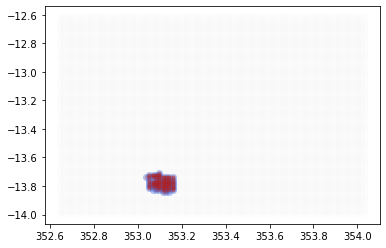

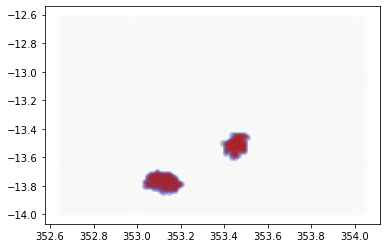

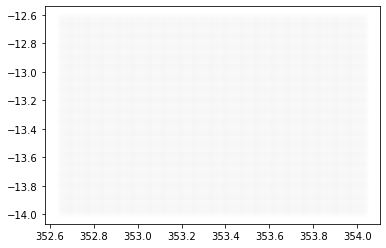

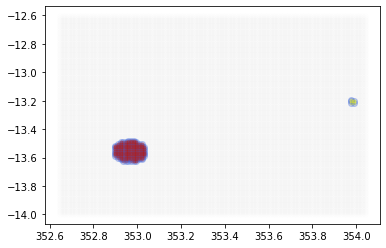

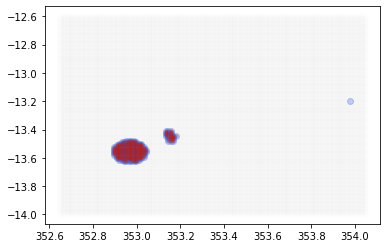

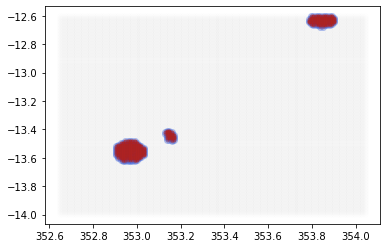

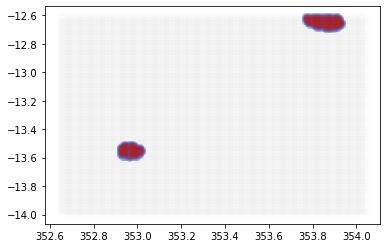

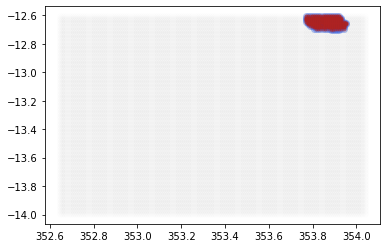

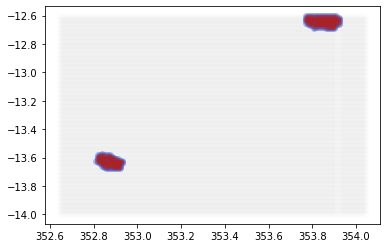

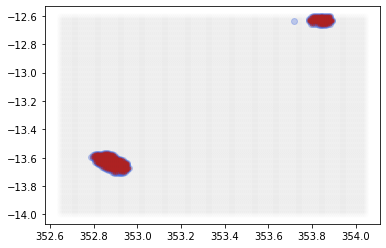

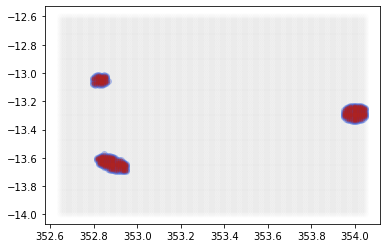

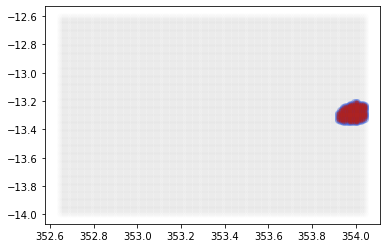

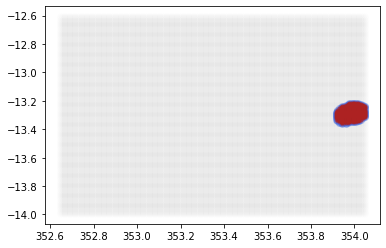

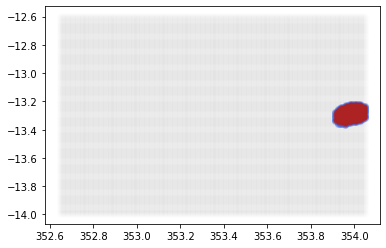

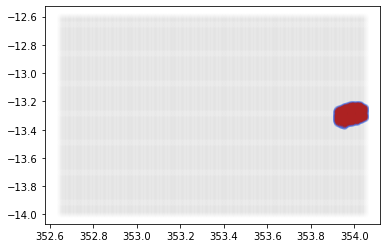

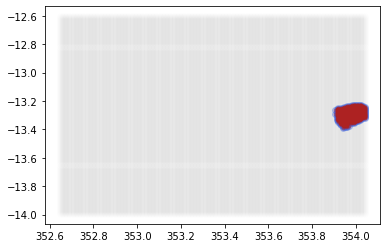

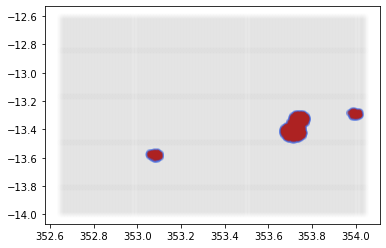

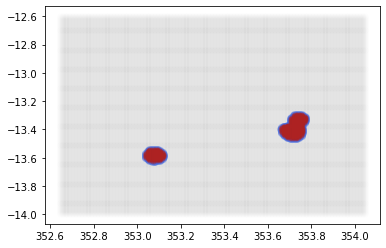

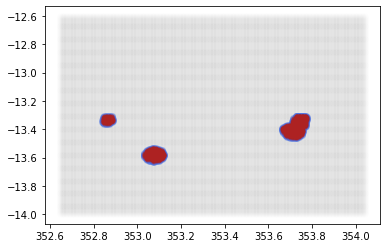

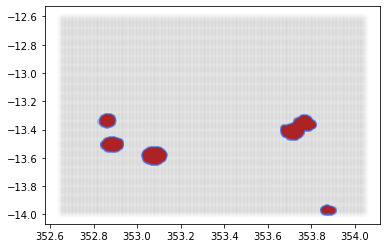

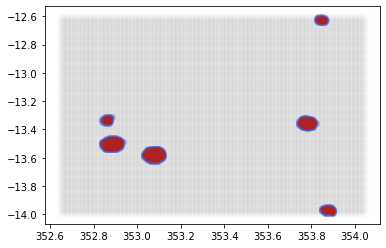

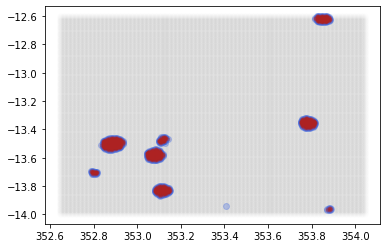

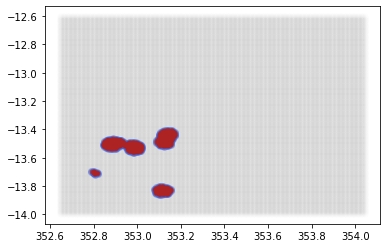

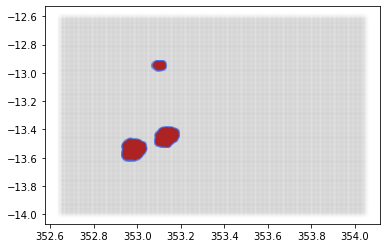

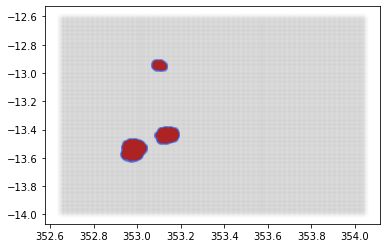

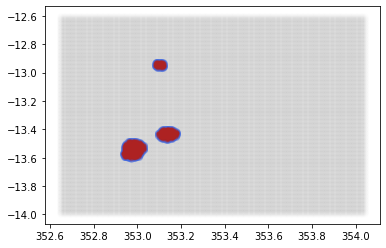

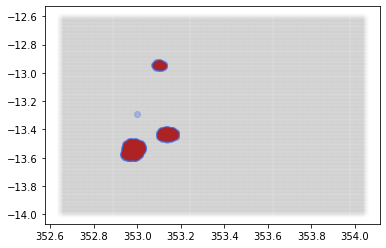

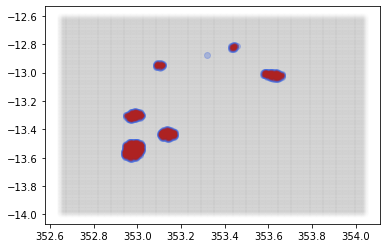

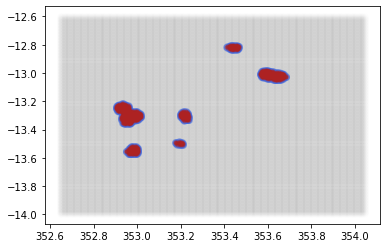

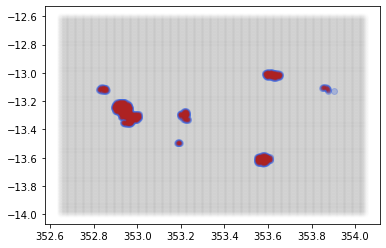

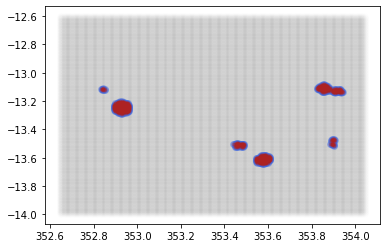

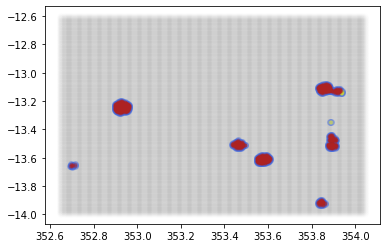

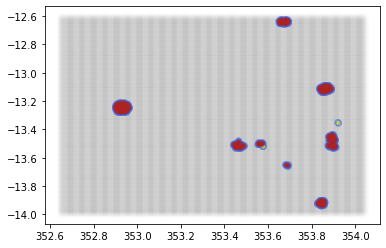

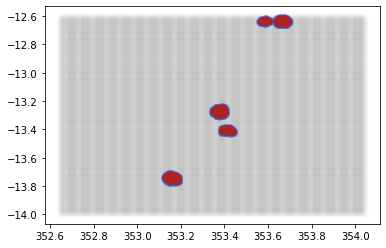

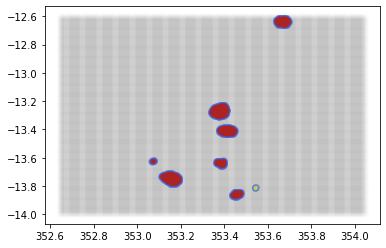

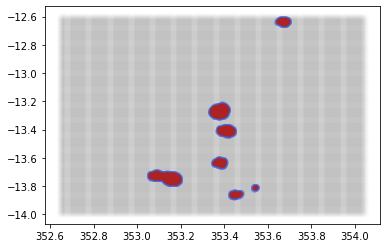

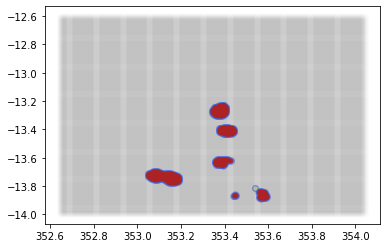

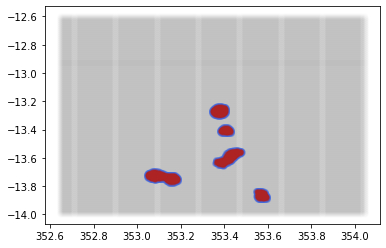

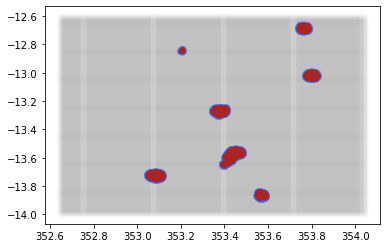

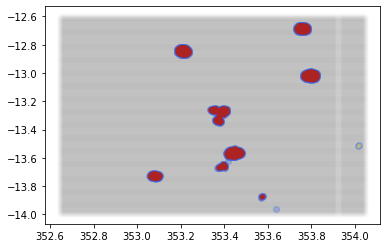

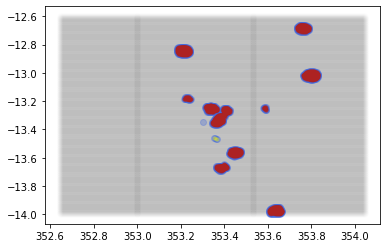

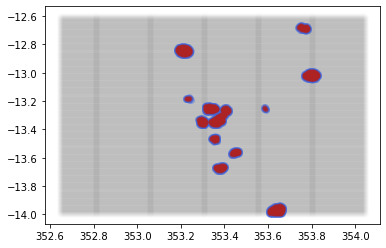

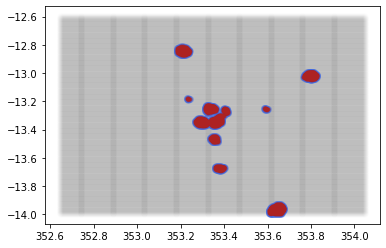

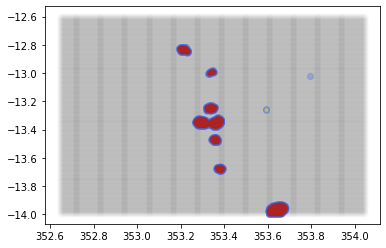

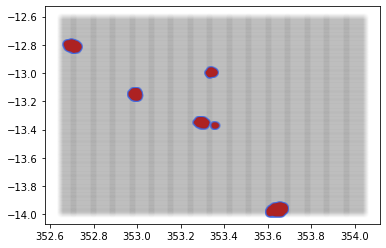

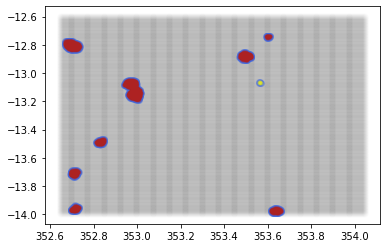

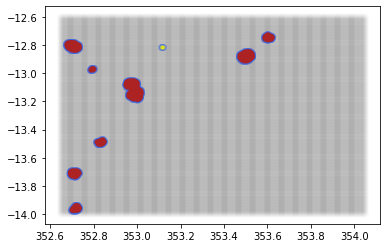

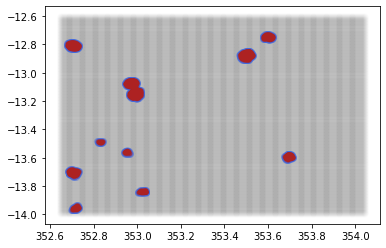

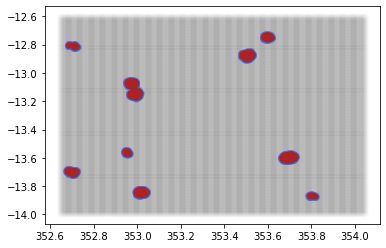

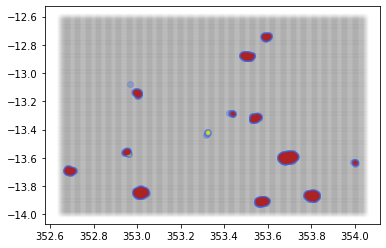

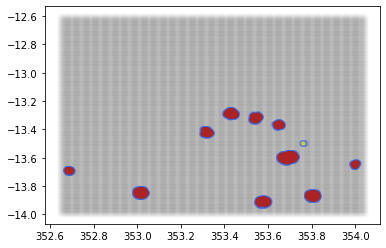

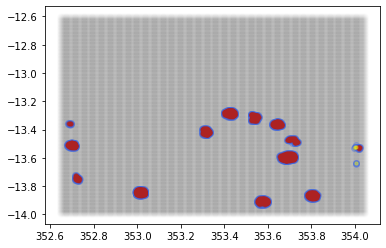

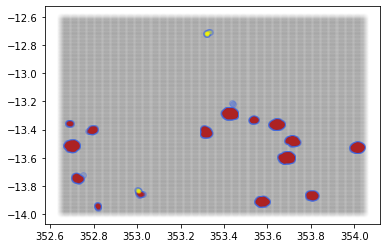

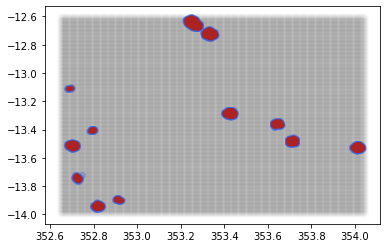

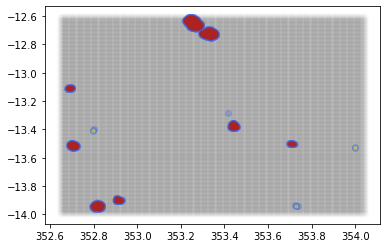

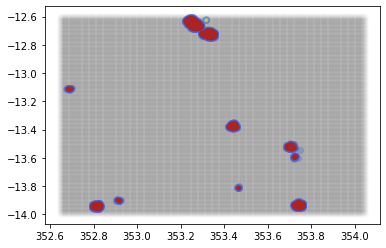

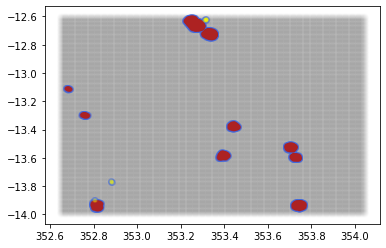

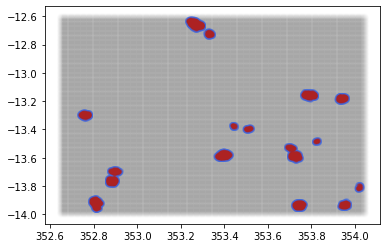

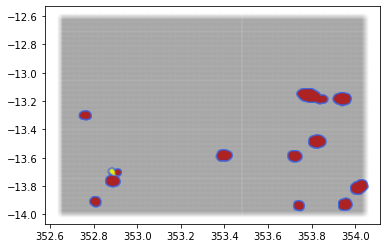

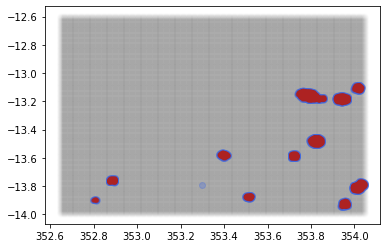

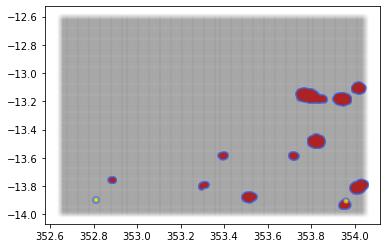

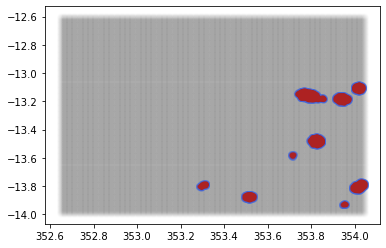

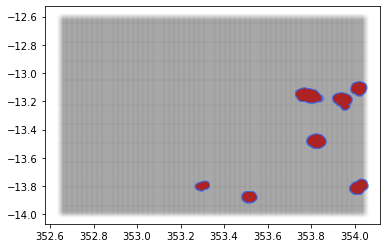

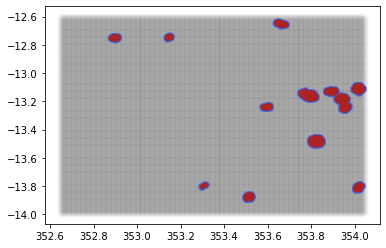

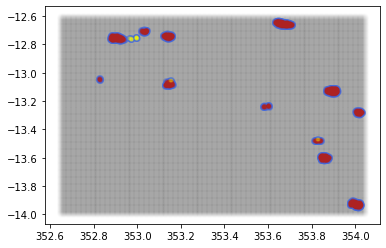

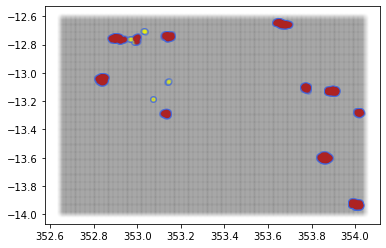

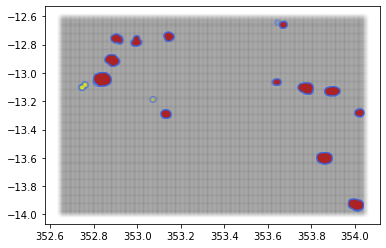

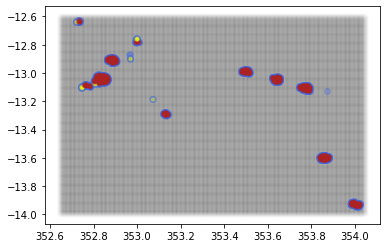

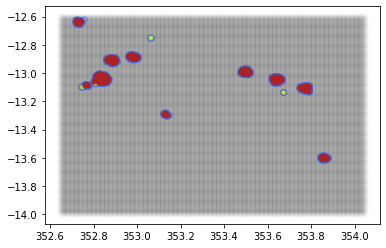

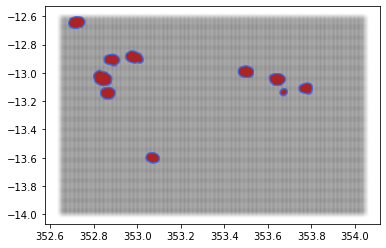

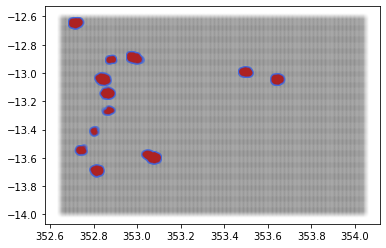

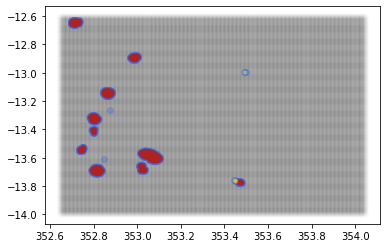

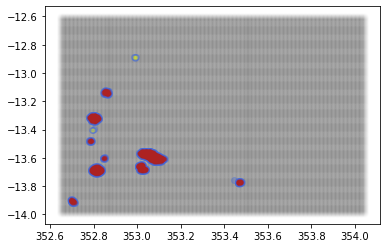

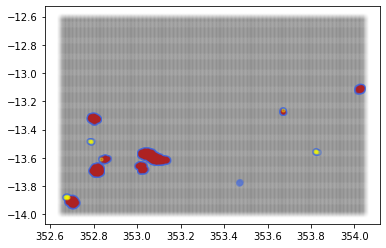

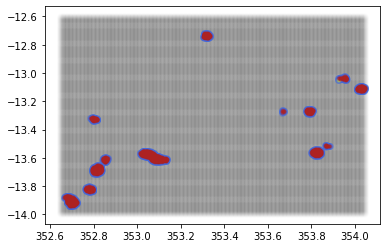

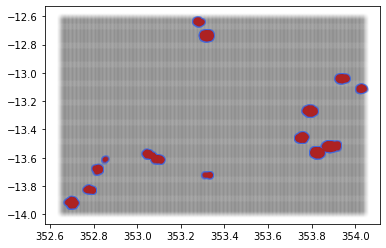

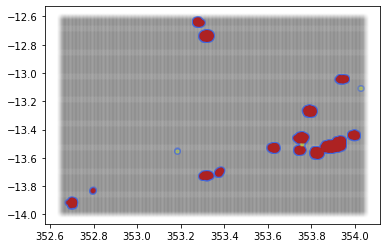

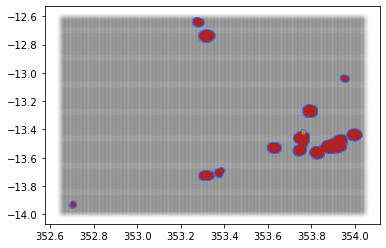

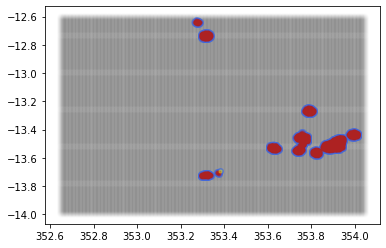

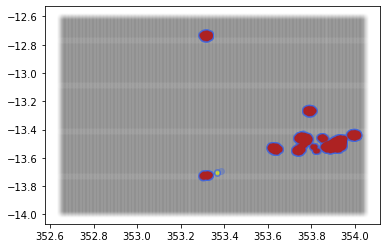

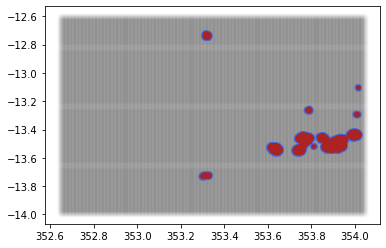

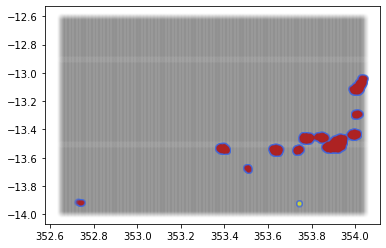

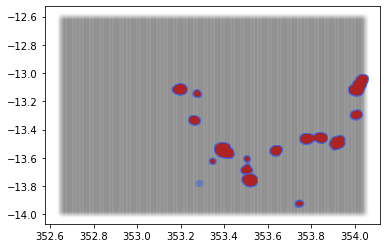

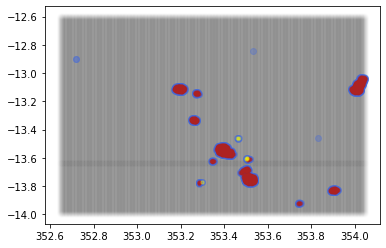

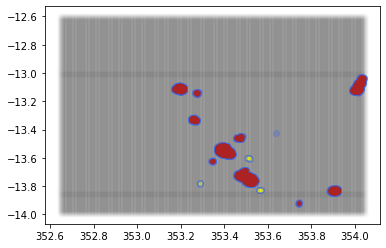

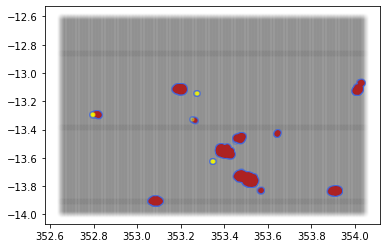

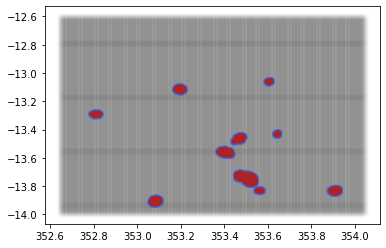

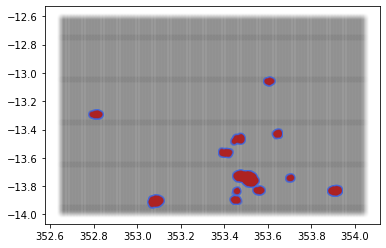

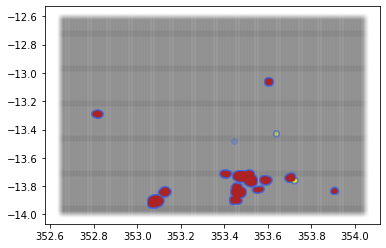

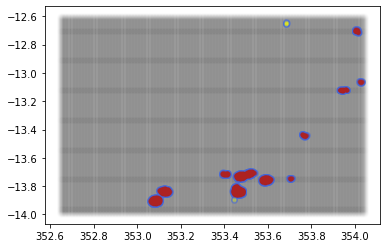

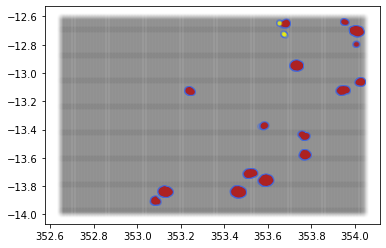

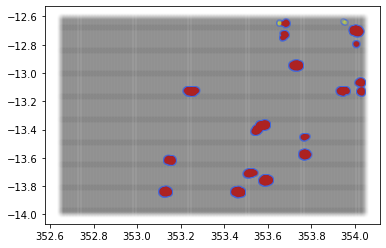

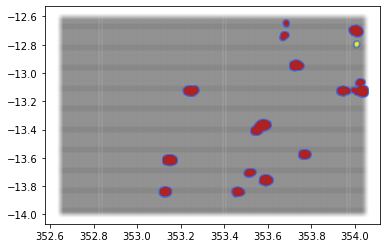

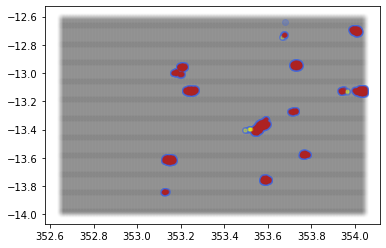

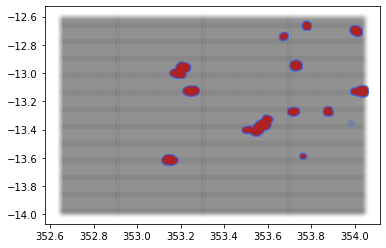

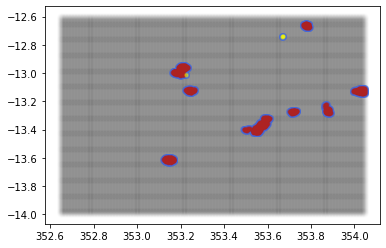

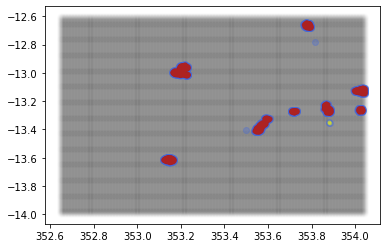

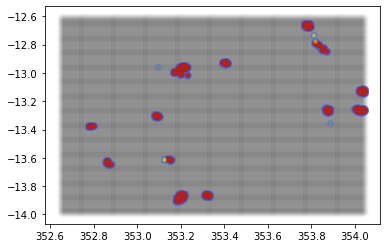

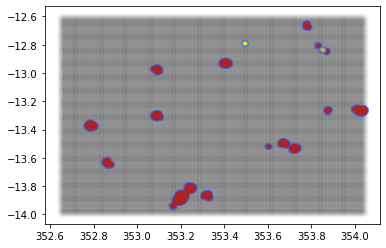

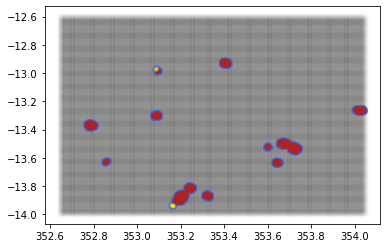

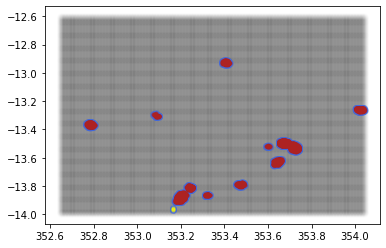

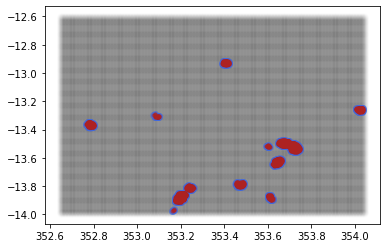

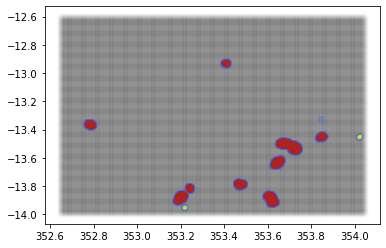

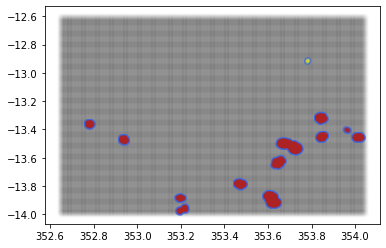

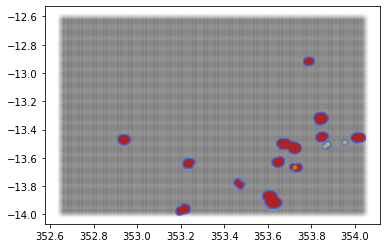

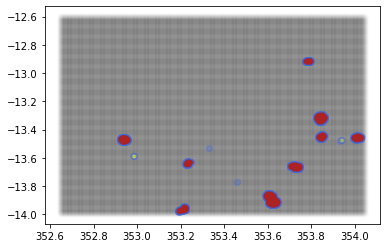

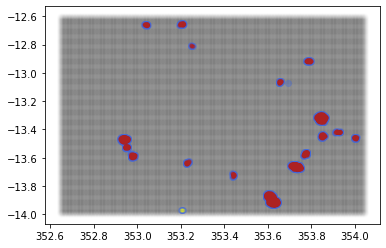

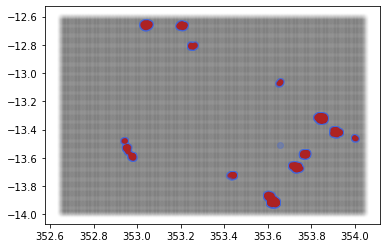

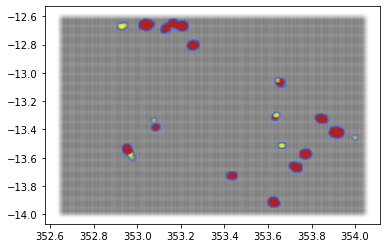

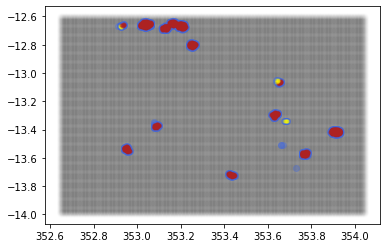

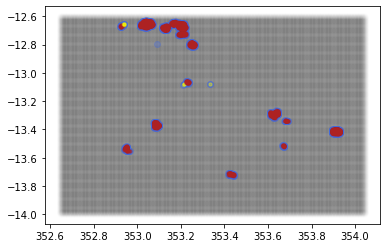

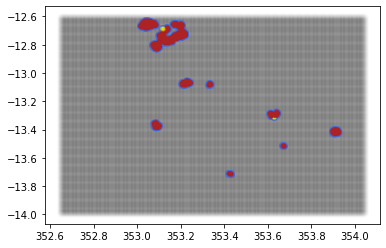

In [29]:
s = 0

file_listz = os.listdir(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz')
file_listz.sort()

xlistz = os.listdir(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/grid_x/')
ylistz = os.listdir(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/grid_y/')

xlistz.sort()
ylistz.sort()

od_ra, od_dec, od_z = overdense(4)

index1, index2, z_idx = find_connection(od_ra, od_dec, od_z)

####

In [30]:
len(index1)

100

In [ ]:
# columns
# ras, decs, haloID, galID, mass, hmass, redshift

In [31]:
# set seed
np.random.seed(s)

# set field boundaries
ra_c = np.random.uniform(351, 354, 1)[0]
dec_c = np.random.uniform(-16.5, -13, 1)[0]


samp_mask = (ras >= ra_c) & (ras < ra_c + 1.4) & (decs >= dec_c) & (decs < dec_c + 1.4)

ras_sample = ras[samp_mask]
decs_sample = decs[samp_mask]
specz_sample = zs[samp_mask]

zerrs = np.random.normal(0, 0.01, len(specz_sample))

photz_sample = specz_sample + zerrs

In [39]:
all_mems = []

for i in range(len(index1)):
    
    print(i, end = ' ')
    
    final_mems = []
#     final_ras = []
#     final_decs = []
#     final_zs = []
    
    for j in range(len(index1[i])):
        z_mems = []
#         z_ras = []
#         z_decs = []
#         z_zs = []
        for k in range(len(od_ra[index1[i][j]][index2[i][j]])):
            ra = od_ra[index1[i][j]][index2[i][j]][k]
            dec = od_dec[index1[i][j]][index2[i][j]][k]
            
            
            zz = redshifts[index1[i][j]]
            
            search = find_radius(zz, 0.1)
            
            
            mem_mask = (ras_sample - ra)**2 + (decs_sample - dec)**2 < search**2
            mem_mask2 = (photz_sample > zz - 0.015 * (1+zz)) & (photz_sample < zz + 0.015 * (1+zz))
            
            mems = galID_arr[samp_mask][mem_mask & mem_mask2]
            
            z_mems.extend(mems.tolist())
            
        final_mems.extend(np.unique(z_mems).tolist())

    all_mems.append(np.unique(final_mems).tolist())


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

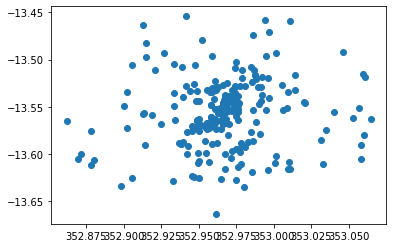

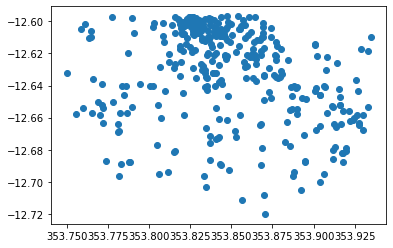

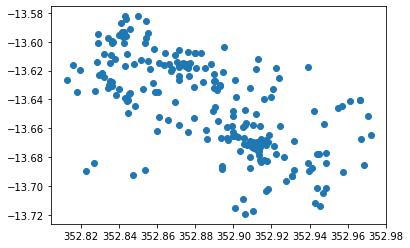

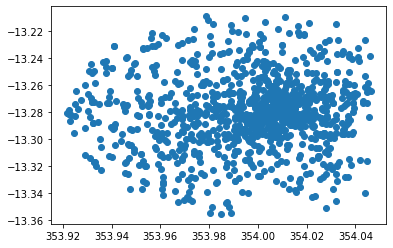

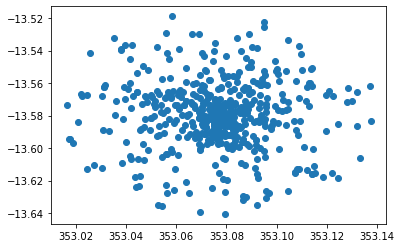

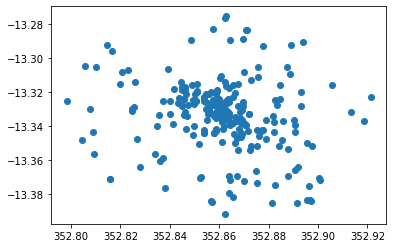

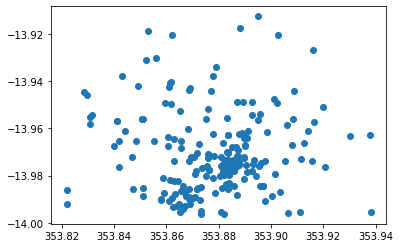

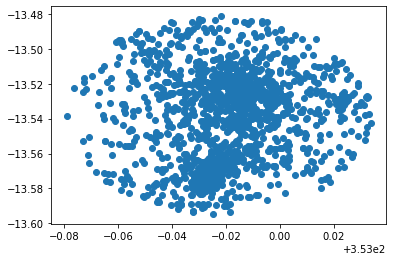

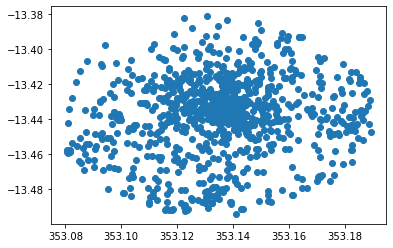

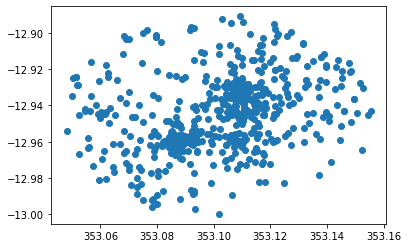

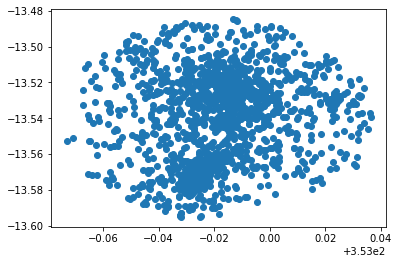

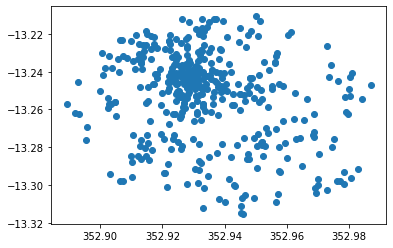

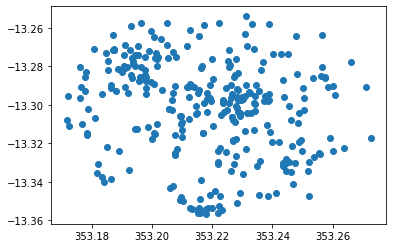

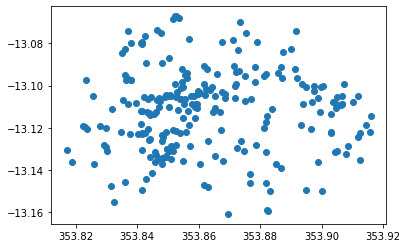

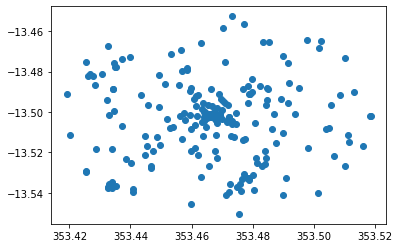

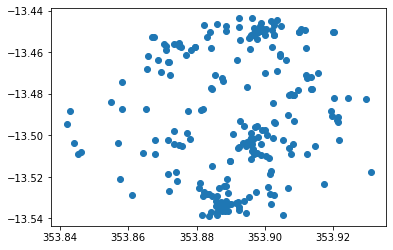

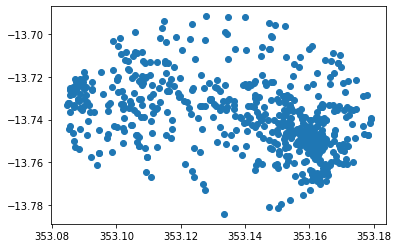

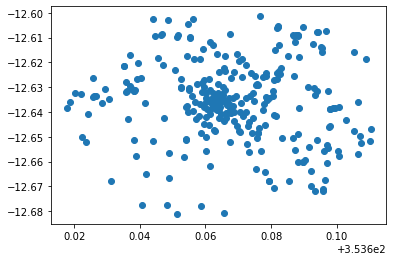

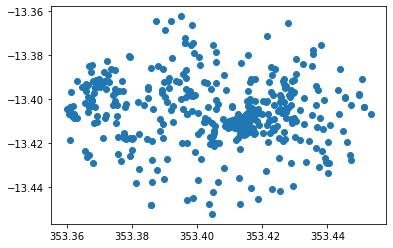

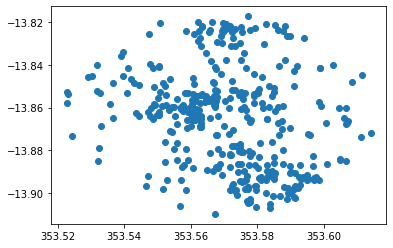

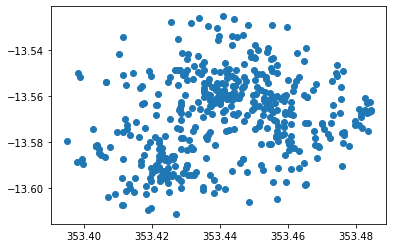

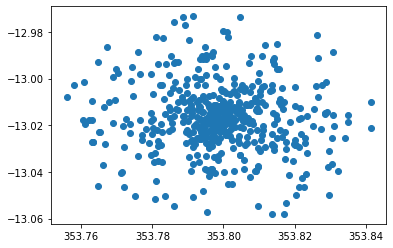

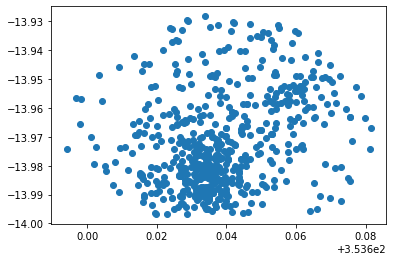

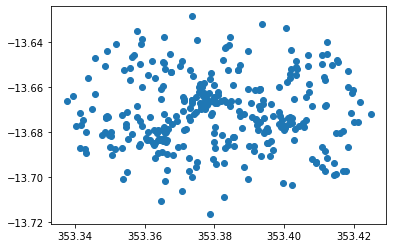

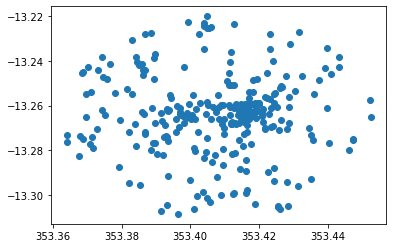

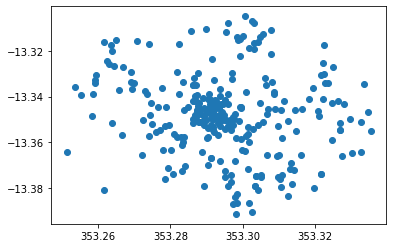

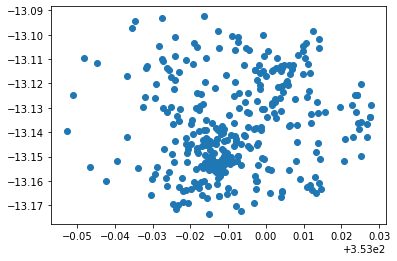

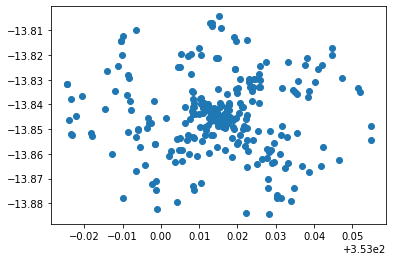

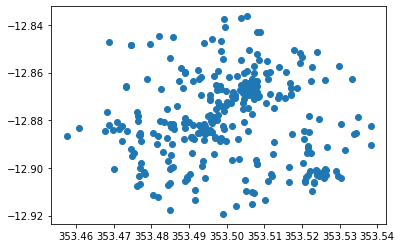

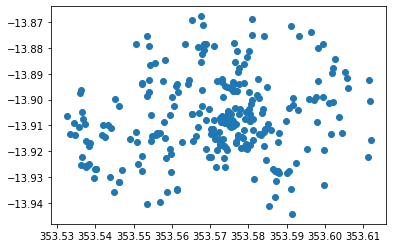

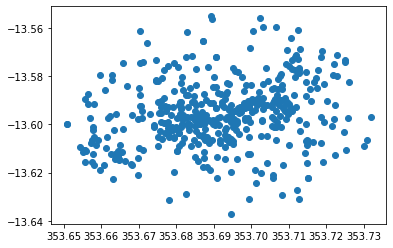

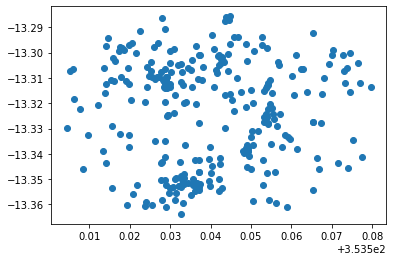

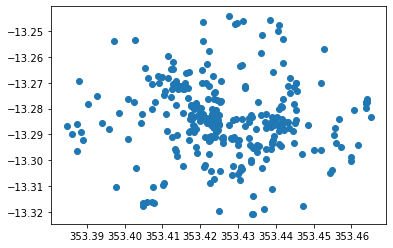

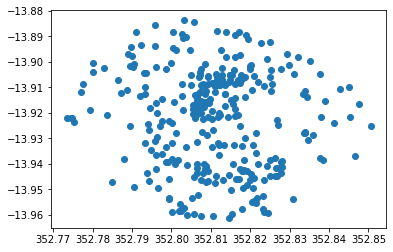

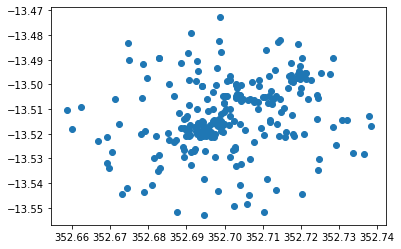

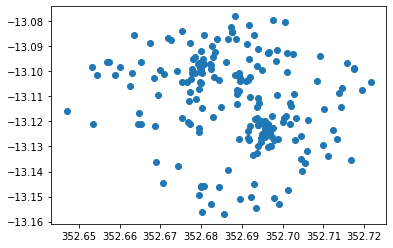

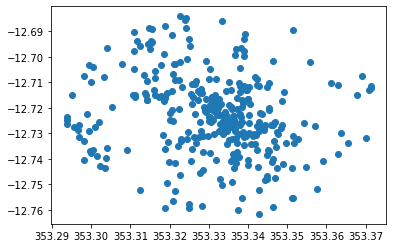

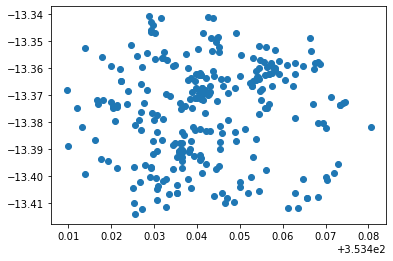

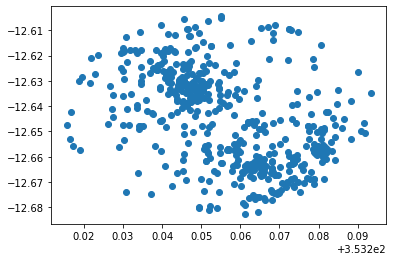

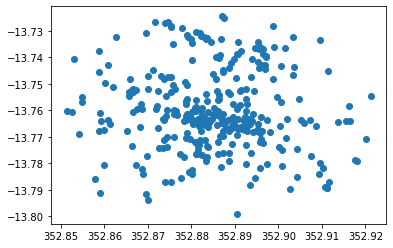

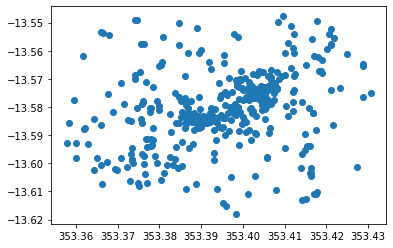

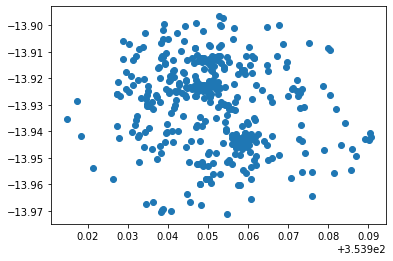

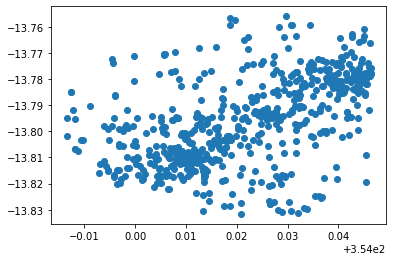

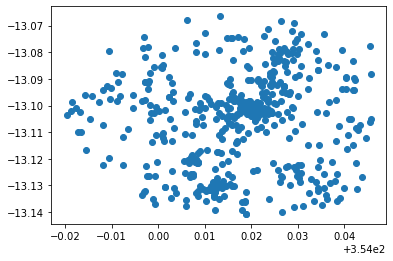

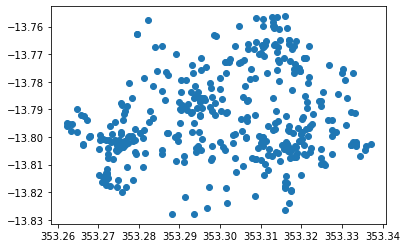

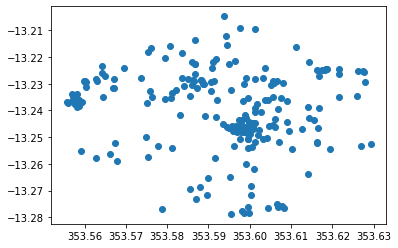

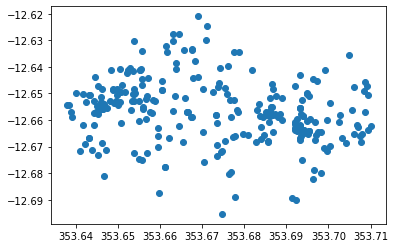

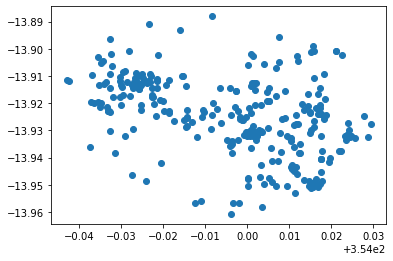

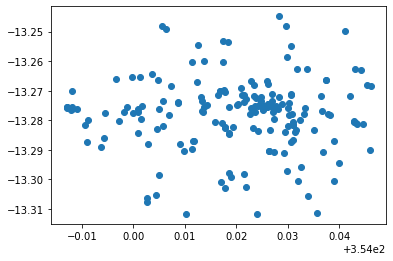

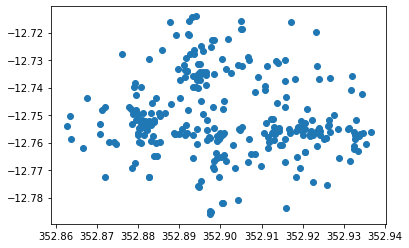

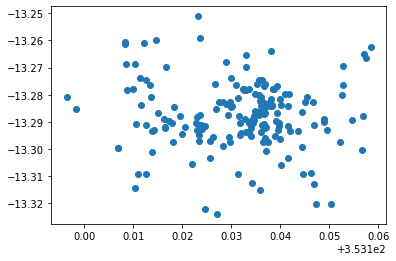

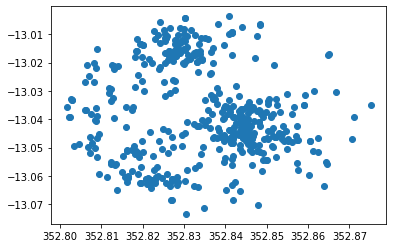

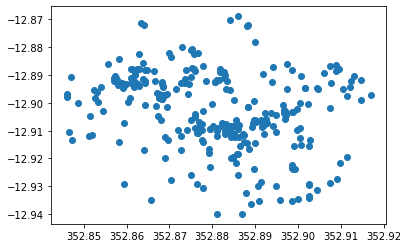

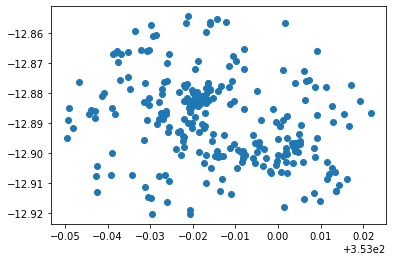

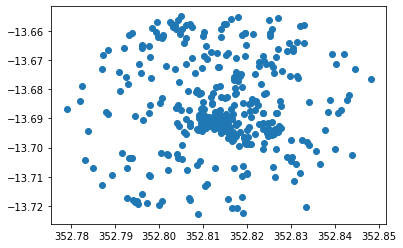

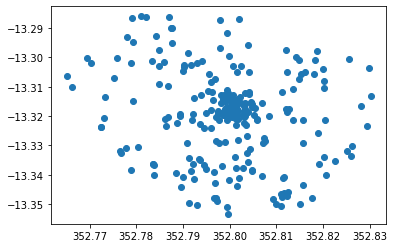

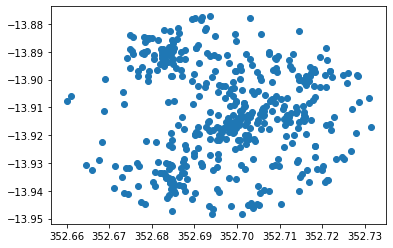

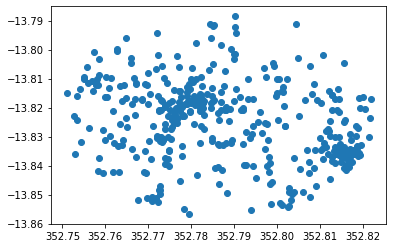

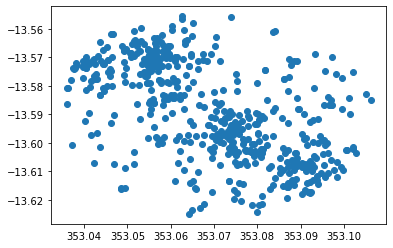

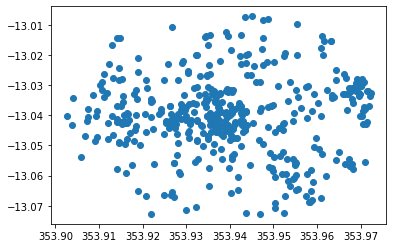

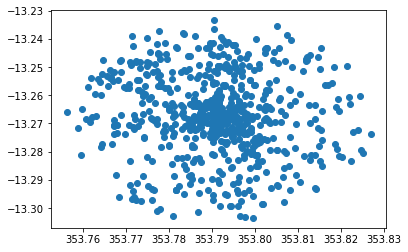

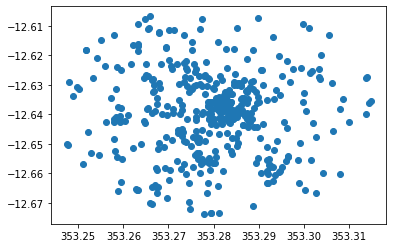

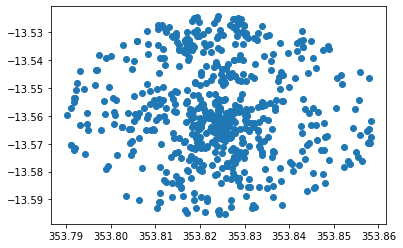

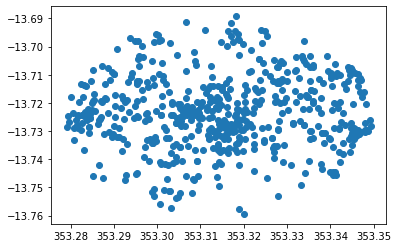

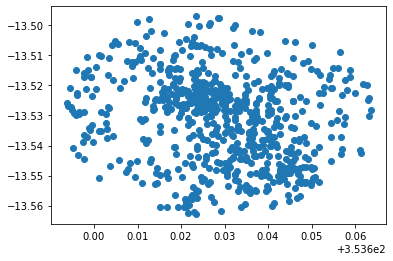

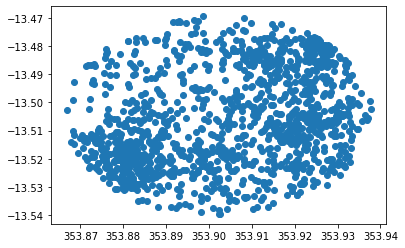

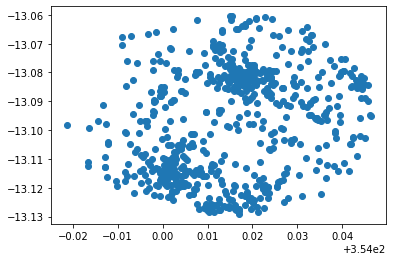

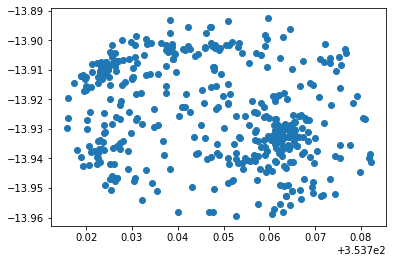

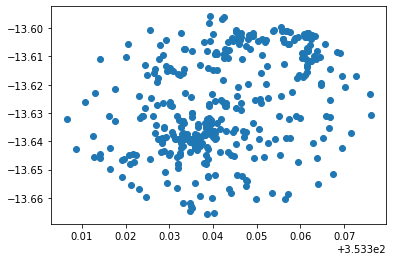

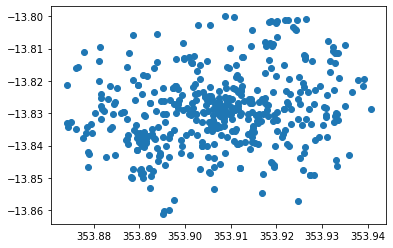

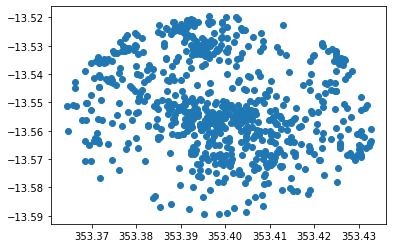

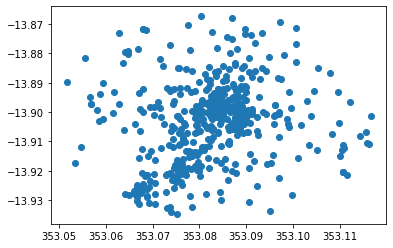

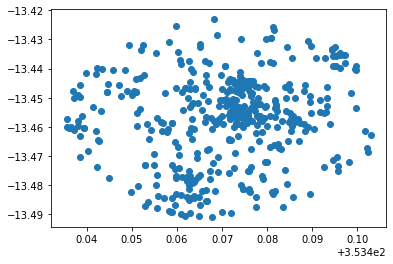

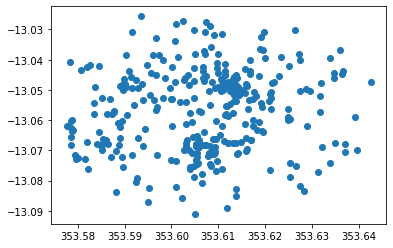

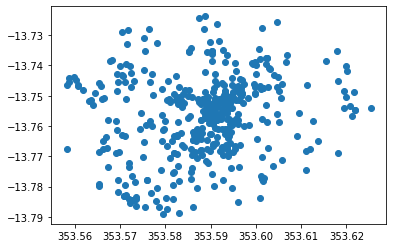

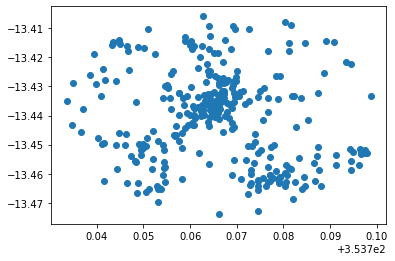

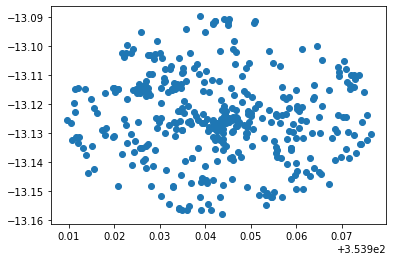

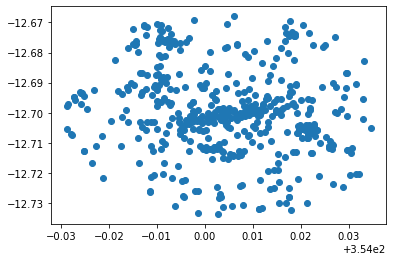

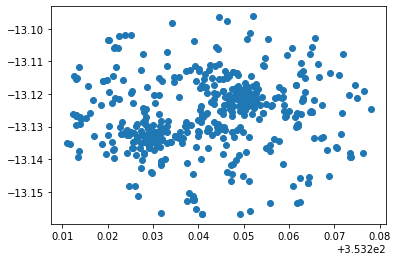

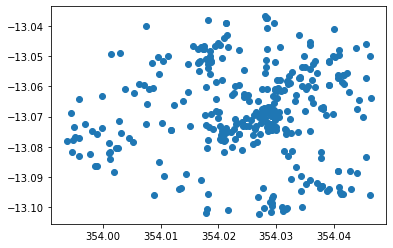

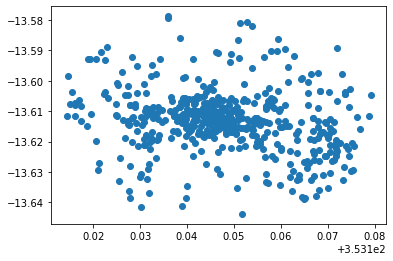

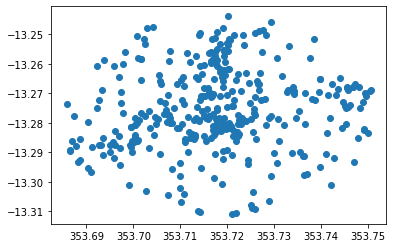

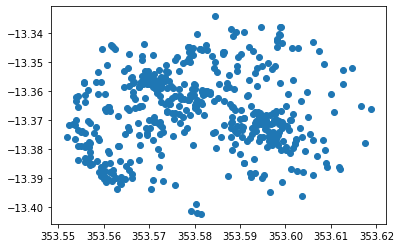

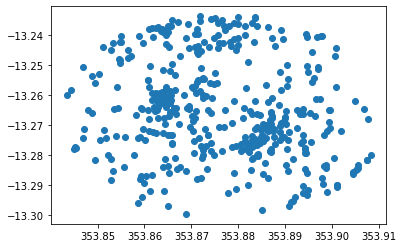

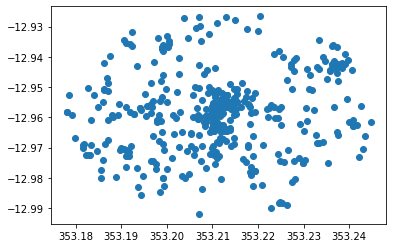

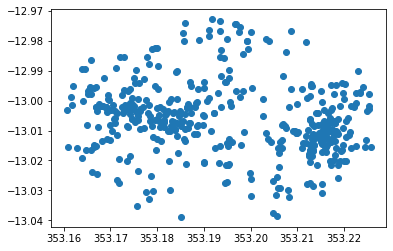

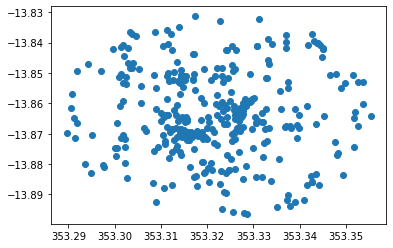

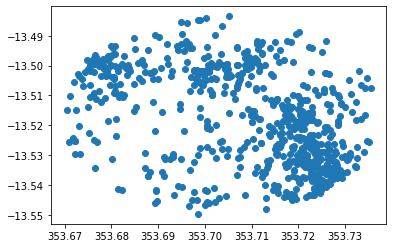

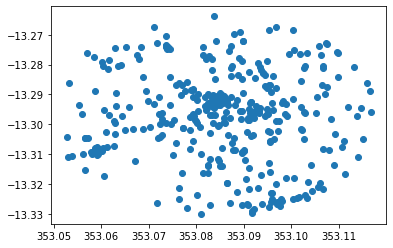

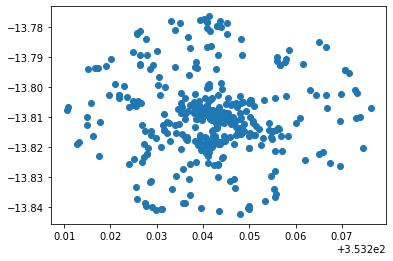

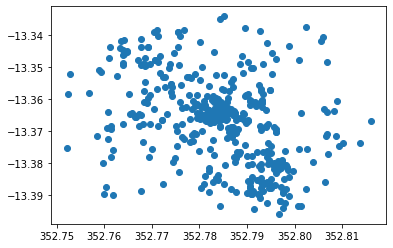

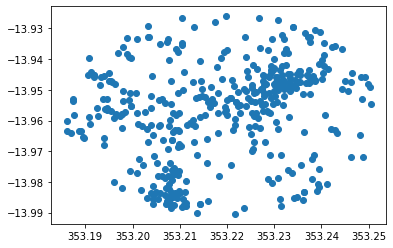

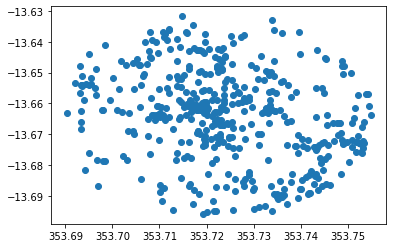

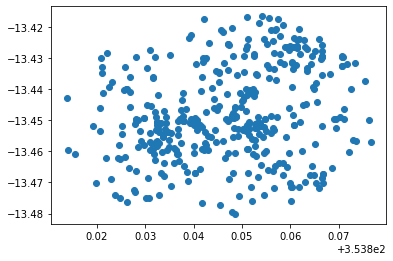

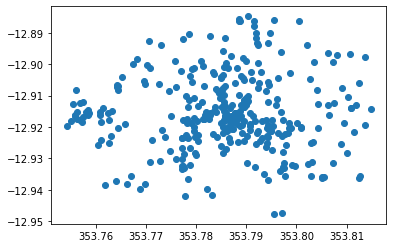

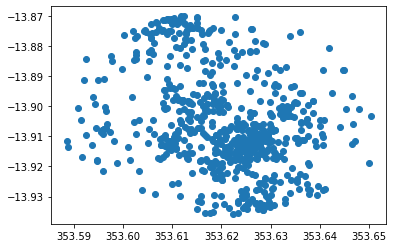

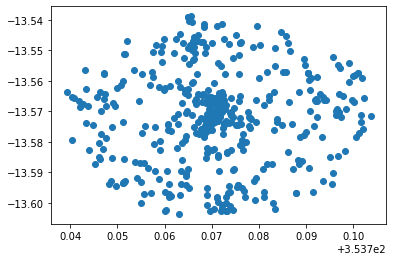

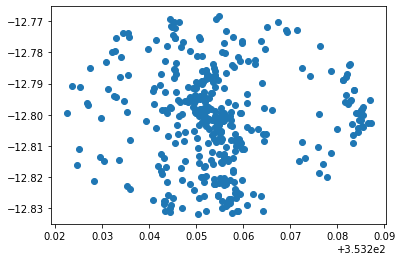

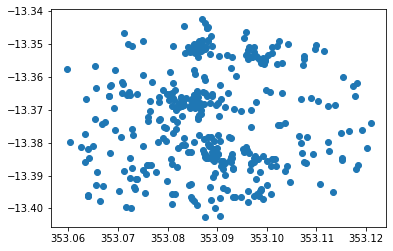

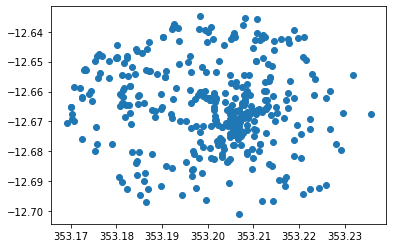

In [82]:
final_members = []
final_ras = []
final_decs = []
final_zs = []

for i in range(len(all_mems)):
    
    print(i, end = ' ')
    
    smask = np.isin(galID_arr[samp_mask], all_mems[i])
#     smask = np.where(idx_mask)[0]
    
    z = np.mean(photz_sample[smask])
    
    search = find_radius(z, 1)
    mmask = (ras_sample - np.mean(ras_sample[smask]))**2 + (decs_sample - np.mean(decs_sample[smask]))**2 < search**2
    mmask2 = (photz_sample > z - 0.015 * (1+z)) & (photz_sample <  z + 0.015 * (1+z))
    
    members = galID_arr[samp_mask][mmask & mmask2]
    
    ra = sum(hmass[samp_mask][mmask & mmask2] * ras_sample[mmask & mmask2]) / sum(hmass[samp_mask][mmask & mmask2])
    dec = sum(hmass[samp_mask][mmask & mmask2] * decs_sample[mmask & mmask2]) / sum(hmass[samp_mask][mmask & mmask2])
    zz = sum(hmass[samp_mask][mmask & mmask2] * photz_sample[mmask & mmask2]) / sum(hmass[samp_mask][mmask & mmask2])
    
    final_ras.append(ra)
    final_decs.append(dec)
    final_zs.append(zz)
    
    fmask1 = (ras_sample - ra)**2 + (decs_sample - dec)**2 < search**2
    fmask2 = (photz_sample > zz - 0.015 * (1+zz)) & (photz_sample <  zz + 0.015 * (1+zz))
    fmems = galID_arr[samp_mask][fmask1 & fmask2]
    
    final_members.append(fmems.tolist())
    
    plt.figure()
    plt.scatter(ras_sample[fmask1 & fmask2], decs_sample[fmask1 & fmask2])

In [83]:
final_ras = np.array(final_ras)
final_decs = np.array(final_decs)
final_zs = np.array(final_zs)

In [84]:
#save index of overdense region
with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/ras.txt', 'wb') as f:
    pickle.dump(final_ras, f)

with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/decs.txt', 'wb') as f:
    pickle.dump(final_decs, f)

with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/zs.txt', 'wb') as f:
    pickle.dump(final_zs, f)
    
with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/members.txt', 'wb') as f:
    pickle.dump(final_members, f)


# Simulation

In [ ]:
with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/ras.txt', 'rb') as f:
    final_ras = pickle.load(f)

with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/decs.txt', 'rb') as f:
    final_decs = pickle.load(f)

with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/zs.txt', 'rb') as f:
    final_zs = pickle.load(f)

with open(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/members.txt', 'rb') as f:
    final_members = pickle.load(f)


## phot-z vs halo ID match

In [85]:
for i in range(len(final_members)):
    
    idx_mask = np.isin(galID_arr[samp_mask], final_members[i])
    
    hals = haloID_arr[samp_mask][idx_mask]
    
    vals, count = np.unique(hals, return_counts = True)
    
    vals[np.argmax(count)]
    
    
    print(count)

[  1 206   2   1   1   1   1   1   1   1   2   1   1   1   1   1   1   1
   1   2   2   1   1   1   1   1   1   1   1   1   2]
[  2   1   1   1   1 292  10   3   1   1   1   1   1   1  11  11   1   1
   1   1   1   1   1   1   1   1   2   1   1   1]
[  2   1   1   1   1   1   2   3   1   1   1   1   1   1   1 161  16  19
   1   1   1   1   1   1   2]
[   1    1    1    1    3    2    1    1    1    1    1 1005    1    1
    1    1    1    1    1    1    2    1    1    6    4    1    5    1
    1    1    5   10    1    4    2    2    4    2    1    1    2    1
    2    1    1    1    1    1    1    1    1    1    1    1    1]
[  1   1   1   1   1   1   1   1   3   2   1 500  10   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1]
[  1   1   1   1   1   1   1   1   1 192   1   1   1   1   1   1   1   1
   5   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1]
[  1   1   1   1   2 130   4   1   1   1   1  51   1   1   1   1   1   2
   

[ 1  1  1  1  1  2  1  1  1  1 48 15  7  1  1  1  1  1 22 12  1  1  1  1
  1  1  1  1  1  1  1  1  1 29  2  1  1  3  1  1 10  1  1  4  2  1  3  2
  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  5  1  3  1 21  1  1  1  1
  1  1  2  1  1  2  1  2  1  1  1  1  1]
[  1   1   5   1   1   2   2   1   1   1   1   1   1   1   1   1   1   1
 191   1   1   1   1   1   1   1   1   1   1   2   2   1   1   1   1   6
   1   1   1   1   2   1   1   1   1   1   2   8   1   5   1   4   2   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1]
[ 45   1   1   1   1   4   1   1   1   1   1   1   1   1   1   1  11   1
   2   1   1  12   1   1   1   1   1   1   1   1   1   1   1   1   1   1
 138   1   1   3   1   1   1   1   1   1   1   1   1   1   1   1   1   3
   1   6   1   1   2   1   1   1   4   1   1   1   1   1   3   5   2   1
   1   1   1   1   1   2   2   1   1   1   1   1   1 

[ 65   3   2   1   1   4   2   1   1   1   1   1   1   1   1   2   1   2
   1   1   3   1   1   2   1   1   2   1   1   1   1   1   1   1   1   1
   1   1   1   1   3   1 114   1   1   1   1   1   1   1   1   1   2   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1  59   1   7   1
   1   1   1   1   1   1   1   1   1   2   2   1  29   3   1   1   3  15
   7   2   1   1   1   1   1   1   2   1   1   3   1   1   1   2   1   1
   3   1   1   4   5   1   3   1   1   1   2   2   1   1   1   1   1   1
   1   2   1   1   1   1   1   1   1]
[127   2   1   1   1   1   2   2   1   1   1   1   2   1   1   2   1   2
   1   1   3   1   1   1   1   1   1   1   1   3   1   1  19   3   1   1
   1   1   2   1   1   2   2   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1  84   1   1   1   2   1   1   3   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   2   1   1   1   1   1   1   1   1   1
   1   1   1 

[  1   1   1   1   1   1   2   1   2   1   1   1   1   3   1   1   1   1
   1 140   3   1   1   1   1   4   1   1   1   1   1   1   1   7   2   2
   1   1   3   1   1   1   1   2   1  67   4   1   1   1   1   1   1   1
   1   2   1   1   1   1  40   1   1   1   1   1   1   1   1   1   1   1
  17   1   6   1   1   1   6   1   1   1   3   1   1   1   1   1   2   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   4   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   4   1]
[  1   1   1   1   1   1   1   1   1   2   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1  29   1   2   2
   1   1   2   1   1   1   2   1   2   1   1   2   1   3   7   7   1   1
   2   2   3   1   1   3   1   1   1   1   1   1 131   1   5   1   2   1
   1   1   4   2   1   1   1   1   1   1   1   1   2   1   1   1   2   1
   1   1   1   1  20   8   1   1   1   1   1   1   1   1   1   1   1   1
   2   1   2   1   1   1   1   1   1 

[  1   1   1   1   1   1   2   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   2   1   1   1   1   1 118  17   2   1   1   1
   1   1   1   1   1   1   1   1   1   1   1  79   3   1   1   1   4   1
   1   1   1   1   1   1   1   1   1   1   2   4   2   1   1   1   1   1
   1   1  13   2   4   2   1   1   1   1   1   1   1   1   2   1   1   1
   3   1   1   3   1   1   1   1   2   1   2   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   6  34   1   2   1   1   1   1   1   1   4
   1   1   1   2   1   1   1   1   1   1   1   2   1   1   1   3   3   1
   1   3   1   1   1   1   2   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1  11   1   1   1   2   1   1   1   1   1   1   1   1   1   1   1]
[ 1  1  1  2  1  1  1  1  1  1 16  1  1  1  1  1  1  1  3  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 35  1  1  1  1  1 10  1  1  1  1  1  

[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   3   1   1
   1   1   1   1   1   1   1 302  19   1   1   2   1   1   1  32   4   5
   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   2   1   1   1   1   1   1   1   1   2   1   2   1   1   1   1   2  76
   1   1   1   1   1   1   1   1   1   6   2   1   1   1   1   1   1   1
   2   1   1   1   1   1   1  23   1   1   1   2   1   1   2   2   2   2
   1   1   1   1   1   1   1   1   1   1   2   6   1   1   1  19   1   1
   3   1   1   1   1   8   2   1   1   1   3   1   2   1   1   2   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   2   1   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   2   2   1   4   2   1   1   1   1   1   1   1   1   1   1   1]
[ 1  1 38  1  1  1  2  1  1  1 19  1  1  1  1  1  1  1  2  1  1  1  4  1
  1  3  1  1  1  1  9  1  1  1  2  1  1  1  1  1  1  1  1  1  6  2  1  1
  2  1  1  1  2  1  1  1  1  1  1  1  1  1  2  1  1  1  2 

## FoF fraction: phot-z vs physical distance

In [87]:
def find_fofs(cra, cdec, fof_ra, fof_dec, z_index, ll):
    
    check = np.full(fof_ra.shape, True, dtype = bool) #index
    print(f'total {len(fof_ra)} grid points')
    #2Mpc
    gstep = find_radius(redshifts[z_index], ll)

    f1mask = (cra - fof_ra)**2 + (cdec - fof_dec)**2 <= gstep**2
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        print('no first friend found')
        return 
    
    new_index = []
    
    temp_index = []
    
    first = True
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
#         print(len(cand_index))
#         print(cand_index)
        for j in range(len(cand_index)):
            f2mask = (fof_ra[cand_index[j]] - fof_ra)**2 + (fof_dec[cand_index[j]] - fof_dec)**2 < gstep**2
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index)  == 0:
                continue
                
            temp_index.extend(list(f2_index))
        new_index.extend(temp_index)
        if len(temp_index) == 0:
            break
#     print(new_index)
    f1_index.extend(new_index)
    final_index = f1_index
    return final_index

In [88]:
def find_bs(z, los):
    
    blist = np.arange(0.0001, 0.05, 0.0001)
    
    dmin = 10000
    darg = 10000
    for i in range(len(blist)):
        dist = cosmo.comoving_distance(z + blist[i]) - cosmo.comoving_distance(z - blist[i])

        if np.abs(dist.value - los) < dmin:
            dmin = np.abs(dist.value - los)

            darg = i
    return blist[darg]

In [90]:
fofs_photz = []

for i in range(len(final_members)):

    z = final_zs[i]
    bs = find_bs(z, 200)

    z_index = np.argmin((redshifts - final_zs[i])**2) 

    grid = np.load(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/' + file_listz[z_index])

    #grid separation = 0.1Mpc
    bs = binsize[z_index] #binsize
    z = redshifts[z_index]

    grid_x = np.load(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/grid_x/' + xlistz[z_index])
    grid_y = np.load(f'./mmodel/BzKdeep/seeds/seed{s:02d}/binsz/grid_y/' + ylistz[z_index])


    grid_1d = np.concatenate(grid)

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std

    grid_od = (grid - mean) / std

    search = find_radius(z, 10)
    area_mask = ((grid_x - final_ras[i])**2 + (grid_y - final_decs[i])**2 < search**2)
    
    findex = find_fofs(final_ras[i], final_decs[i], grid_x[area_mask&overdense_mask2], grid_y[area_mask&overdense_mask2], z_index, 1)    

    fof_z = len(grid_x[area_mask & overdense_mask2][findex]) / len(grid_x[area_mask])
    fofs_photz.append(fof_z)

#     fig, ax = plt.subplots(figsize = (5, 5))
#     ax.scatter(grid_x[area_mask&sparse_mask2], grid_y[ area_mask& sparse_mask2], color = 'grey', s = 1)
#     ax.scatter(grid_x[ area_mask&overdense_mask2], grid_y[area_mask& overdense_mask2], color = 'salmon', s = 1)
    
#     ax.set_title(f'{i}')
    
#     ax.scatter(grid_x[ area_mask & overdense_mask2][findex], grid_y[area_mask & overdense_mask2][findex], color = 'firebrick', alpha = 1, s = 1)

#     ax.scatter(mems['RA_true'], mems['DEC_true'], color = 'royalblue', marker = 'x', alpha = .5)
 

total 569 grid points
total 551 grid points
total 604 grid points
total 591 grid points
total 734 grid points
total 907 grid points
total 393 grid points
total 1349 grid points
total 1698 grid points
total 1267 grid points
total 1347 grid points
total 1586 grid points
total 2740 grid points
total 1692 grid points
total 1306 grid points
total 2348 grid points
total 2285 grid points
total 529 grid points
total 2386 grid points
total 2488 grid points
total 2659 grid points
total 1175 grid points
total 578 grid points
total 1959 grid points
total 2564 grid points
total 2493 grid points
total 1715 grid points
total 1178 grid points
total 1181 grid points
total 933 grid points
total 2488 grid points
total 2062 grid points
total 1920 grid points
total 928 grid points
total 1172 grid points
total 689 grid points
total 1385 grid points
total 1383 grid points
total 1324 grid points
total 806 grid points
total 865 grid points
total 688 grid points
total 991 grid points
total 1812 grid points
tota

In [93]:
# set seed
np.random.seed(s)

# set field boundaries
ra_c = np.random.uniform(351, 354, 1)[0]
dec_c = np.random.uniform(-16.5, -13, 1)[0]


samp_mask = (ras >= ra_c) & (ras < ra_c + 1.4) & (decs >= dec_c) & (decs < dec_c + 1.4)

ras_sample = ras[samp_mask]
decs_sample = decs[samp_mask]
specz_sample = zs[samp_mask]

zerrs = np.random.normal(0, 0.01, len(specz_sample))

photz_sample = specz_sample + zerrs

In [ ]:
fofs_dist = []

for i in range(len(final_members)):

    z = final_zs[i]
    
    #pm 20Mpc
    bs = find_bs(z, 20)

    zmask = (photz_sample <=  z + bs) & (photz_sample >= z - bs)
    
    print(f'{z : .4f}', end = ' ')
    
    #grid separation = 0.1Mpc
    gstep = find_grid_step(z)
    grid_ra = np.arange(min(ras_sample[zmask]), max(ras_sample[zmask]), gstep)
    grid_dec = np.arange(min(decs_sample[zmask]), max(decs_sample[zmask]), gstep)
    
    grid = np.zeros((len(grid_dec), len(grid_ra)))
    
    print(len(grid_dec))
    for j in range(len(grid_ra)):
#         if(i % 100 == 0):
#             print(i)
        for k in range(len(grid_dec)):
            #within 1Mpc, z -> z_cl +- error
            sr = find_search_radius(z)
            
            sample = ras_sample[zmask][((ras_sample[zmask] -  grid_ra[j])**2 + (decs_sample[zmask] - grid_dec[k])**2 < sr**2)]
            grid[k, j] = len(sample)

    grid_x, grid_y = np.meshgrid(grid_ra, grid_dec)
    

    grid_1d = np.concatenate(grid)

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std

    grid_od = (grid - mean) / std

    search = find_radius(final_zs[i], 10)
    area_mask = ((grid_x - final_ras[i])**2 + (grid_y - final_decs[i])**2 < search**2)

    ###calculation
    findex = find_fofs(final_ras[i], final_decs[i], grid_x[area_mask&overdense_mask2], grid_y[area_mask&overdense_mask2], z_index, 1)    

    fof_d = len(grid_x[area_mask & overdense_mask2][findex]) / len(grid_x[area_mask])
    fofs_dist.append(fof_d)
    
    

 0.1444 127
total 441 grid points
 0.1690 145
total 493 grid points
 0.1936 162
total 711 grid points
 0.2287 184
total 597 grid points
 0.2876 218
total 654 grid points
 0.2877 218
total 1075 grid points
 0.2950 222
total 296 grid points
 0.3480 248
total 1258 grid points
 0.3465 248
total 1612 grid points
 0.3481 248
total 1087 grid points
 0.3504 250
total 1243 grid points
 0.3900 267
total 1878 grid points
 0.3791 262
total 2356 grid points
 0.4064 273
total 1827 grid points
 0.4049 273
total 1444 grid points
 0.4069 274
total 2087 grid points
 0.4578 294
total 1964 grid points
 0.4433 288
total 836 grid points
 0.4530 292
total 2181 grid points
 0.4719 298
total 2204 grid points
 0.4849 303
total 2028 grid points
 0.4991 308
total 1297 grid points
 0.5194 314
total 695 grid points
 0.5092 311
total 1959 grid points
 0.5024 309
total 2649 grid points
 0.5169 314
total 2221 grid points
 0.5682 329
total 2107 grid points
 0.5968 336
total 1004 grid points
 0.5703 329
total 1189 grid 

In [ ]:
def func(x, a, b):
    return a*x + b

popt1, pcov1 = curve_fit(func, fofs_photz, fofs_dist)

xs = fofs_photz
ys = popt1[0] * xs + popt1[1]

plt.figure(figsize = (10, 6))
plt.scatter(fofs_photz, fofs_dist)
plt.plot(xs, ys, color = 'black', linestyle = '-')

plt.xlabel('$F_{FOF}$ from photometric redshift', fontsize = 20)
plt.ylabel('$F_{FOF}$ from comoving distance(20Mpc)', fontsize = 20)